In [8]:
import os
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

import matplotlib.pyplot as plt
import seaborn as sns

base_dir = "C:/Users/Xin/Onedrive - Drexel University/BrainImaging_ML/"
# base_dir = "/home/xin/Dropbox/BrainImaging_ML/"
data_dir = base_dir + "data"

input_dir = "out03_age_prediction_hc2_stdz_age_reverse_notract_fa_scale_thresh.05"
output_dir = "out04_fit_brain_age_disorder_hc2_stdz_age_reverse_notract_fa_scale_thresh.05"

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

model = 'cluster_gmmEEE4'
#model = 'cluster_km4'

method = 'ridge'
# method = 'svrlinear'

## disorder groups and hc test:
scatter_data = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_disorder_" + model + ".csv", 
                           sep = ",", header = 0, index_col=0)

# ## select a subset of strict HCs: this does not work for the hc test updates.
# hc_column = 'mental_hc2'

# ## select mental healthy subjects:
# behav_data = pd.read_csv(data_dir+"/pyresult01_pnc_behav_mental4.csv", delimiter = ",")
# behav_data = behav_data.astype({'SUBJID': 'int64'})
# behav_data["Med_Rating"] = behav_data["Med_Rating"].apply(pd.to_numeric, errors='coerce')
# behav_data = behav_data.loc[behav_data["Med_Rating"]<2,:]
# behav_data_hc = behav_data.loc[behav_data[hc_column]==True, 'SUBJID']
# scatter_data_hc = scatter_data.loc[scatter_data['SUBJID'].isin(behav_data_hc),:]

cluster_idx = scatter_data['cluster'].unique()
num_cluster = len(cluster_idx)

# scatter_data.set_index('cluster', inplace = True)
# scatter_data.sort_index(inplace = True)

# scatter_data.index.astype('str') 
scatter_data['group'].unique()

array(['smry_ptd', 'smry_dep', 'smry_phb', 'smry_soc', 'smry_add',
       'smry_odd', 'HC'], dtype=object)

In [9]:


scatter_data['cluster'].unique()

array(['1.0', '2.0', '3.0', '4.0', 'all'], dtype=object)

In [10]:
# fit brain age to do bias correction for brain age gap:

cluster_list = scatter_data['cluster'].unique()
group_list = scatter_data['group'].unique()

regr = linear_model.LinearRegression()

for icluster in cluster_list:
#     for igroup in group_list[1:]:

    row_index_hc = (scatter_data['cluster']==icluster)&(scatter_data['group']=='HC')
    row_index = (scatter_data['cluster']==icluster)
    
    scatter_data_cluster = scatter_data.loc[row_index_hc,:]
    y_train = scatter_data_cluster.loc[:,'brain age'].values
    X_train = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                         np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))

    ####### fit model with sex and interaction terms:
    X_train = np.hstack((X_train,
                         np.vstack((X_train[:,0]*X_train[:,1])), 
                         np.vstack((X_train[:,0]*X_train[:,2]))))

    # Train the model using the training set
    regr.fit(X_train, y_train)

    # Make predictions using the test set
    scatter_data_cluster = scatter_data.loc[row_index,:]
    X_test = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                        np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))
    
    X_test = np.hstack((X_test,
                         np.vstack((X_test[:,0]*X_test[:,1])), 
                         np.vstack((X_test[:,0]*X_test[:,2]))))
    
    y_pred = regr.predict(X_test)

    scatter_data.loc[row_index, 'brain age fit intersex'] = y_pred

#scatter_data.to_csv(input_dir+'out04_healthy_controls_age_fit.csv')
scatter_data['age gap'] = scatter_data['brain age'] - scatter_data['chronological age']
scatter_data['age gap corr'] = scatter_data['brain age'] - scatter_data['brain age fit intersex']

scatter_data.reset_index(inplace = True)
scatter_data.replace({'Sex': {0: 'F', 1: 'M'}}, inplace = True)

scatter_data.to_csv(input_dir+"/out04_scatter_data_" + method + "_" + model +"_fit_brain_age.csv")


In [11]:
scatter_data['group'] = scatter_data['group'].map({'HC': 'HC',
                                                   'smry_phb': 'Specific Phobia', 
                                                   'smry_soc': 'Social Phobia',
                                                   'smry_dep': 'Depression',
                                                   'smry_ptd': 'PTSD',
                                                   'smry_odd': 'ODD',
                                                   'smry_add': 'ADHD'})

# scatter_data

In [12]:
# correction for Kmeans:

# scatter_data['cluster'] = scatter_data['cluster'].map({'1': '1.0',
#                                                        '2': '2.0',
#                                                        '3': '3.0',
#                                                        'all': 'all',
#                                                       })

In [13]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster']=='1.0',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific Phobia', 
                                                                'Social Phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

demo_summary = scatter_data.loc[scatter_data['cluster']=='1.0', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary

group  sample size  females  age (mean)  age (std)
0               HC           70       35   14.642857   3.791813
1  Specific Phobia          185      120   13.600000   3.191701
2    Social Phobia          142       82   14.457746   2.829989
3       Depression           70       47   16.000000   2.407717
4             PTSD           71       51   15.507042   2.724876
5              ODD          206      112   14.359223   2.519599
6             ADHD          106       51   13.377358   2.983934

In [14]:
# remove subjects with comobidity (with more than one disorder):
# comorbity subject were just removed from the larger disorder group.
scatter_data['group2'] = scatter_data['group'].map({'HC': 'aHC',
                                                   'Specific Phobia': 'fSpecific Phobia', 
                                                   'Social Phobia': 'eSocial Phobia',
                                                   'Depression': 'bDepression',
                                                   'PTSD': 'cPTSD',
                                                   'ODD': 'gODD',
                                                   'ADHD': 'dADHD'})


scatter_data = scatter_data.sort_values(by = ['group2'], ascending = True)
scatter_data = scatter_data.drop_duplicates(['cluster', 'SUBJID'], keep='first')
# scatter_data = scatter_data.drop_duplicates(['cluster', 'SUBJID'], keep=False)


scatter_data['cluster2'] = scatter_data['cluster'].map({'1.0': 'cluster 1',
                                                       '2.0': 'cluster 2',
                                                       '3.0': 'cluster 3',
                                                       '4.0': 'cluster 4',
                                                       '5.0': 'cluster 5',
                                                       'all': 'cluster all',
                                                      })

column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
scatter_data['cluster2'] = pd.Categorical(scatter_data['cluster2'], ordered=True, categories=column_title)
# cat_type = CategoricalDtype(categories=column_title, ordered=True)
# scatter_data['cluster2'] = scatter_data['cluster2'].astype(cat_type)

# cat_type = CategoricalDtype(categories=['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'], 
#                             ordered=True)
# scatter_data['group2'] = scatter_data['group'].astype(cat_type)

scatter_data['group2'] = pd.Categorical(scatter_data['group'], ordered=True,
                                        categories=['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
# scatter_data

In [15]:
scatter_data['group2'].unique().sort_values()

[HC, Specific Phobia, Social Phobia, Depression, PTSD, ODD, ADHD]
Categories (7, object): [HC < Specific Phobia < Social Phobia < Depression < PTSD < ODD < ADHD]

In [16]:
column_title

['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster all']

In [17]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster2']=='cluster 1',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific Phobia', 
                                                                'Social Phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

group
HC                 35
Specific Phobia    46
Social Phobia      43
Depression         47
PTSD               31
ODD                20
ADHD               37
Name: (chronological age, count), dtype: int64

In [18]:
demo_summary = scatter_data.loc[scatter_data['cluster2']=='cluster 1', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary.to_csv(input_dir+"/out04_demo_summary.csv")
demo_summary

group  sample size  females  age (mean)  age (std)
0               HC           70       35   14.642857   3.791813
1  Specific Phobia           70       46   12.571429   3.169471
2    Social Phobia           77       43   14.051948   2.851113
3       Depression           70       47   16.000000   2.407717
4             PTSD           44       31   15.159091   2.836172
5              ODD           48       20   14.562500   2.657036
6             ADHD           81       37   13.086420   2.967312

In [19]:



def qudratic_r_squared(chro_age, brain_age):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c):
        return a + b*x + c*(x**2)
    
    popt, pcov = curve_fit(qudratic_fun, chro_age, brain_age)
    brain_age_pred = qudratic_fun(chro_age, popt[0], popt[1], popt[2])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

def qudratic_r_squared_gender(chro_age, brain_age, gender):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age and gender.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c, d, e, f):
        x1, x2 = x
        #return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 f*(x1**2)*x2
        return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 + f*(x1**2)*x2
    
    popt, pcov = curve_fit(qudratic_fun, (chro_age, gender), brain_age)
    brain_age_pred = qudratic_fun((chro_age, gender), popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

In [20]:
scatter_data

index cluster        SUBJID Sex group  chronological age  brain age  \
4249    943     all  609987705265   M    HC               15.0  15.128088   
815     435     1.0  604836600596   F    HC               11.0  11.923252   
816     441     1.0  604908576947   F    HC               15.0  17.327718   
817     449     1.0  605090380179   M    HC               12.0  11.478647   
818     461     1.0  605266281282   M    HC               11.0  14.375122   
...     ...     ...           ...  ..   ...                ...        ...   
1491    306     2.0  603260783630   F   ODD                9.0  13.302330   
1494    318     2.0  603390032085   M   ODD               15.0  16.236994   
1496    333     2.0  603519353680   M   ODD               18.0  16.811909   
1498    337     2.0  603533144459   M   ODD               12.0  13.617329   
3169    208     4.0  602260470547   F   ODD               18.0  14.652919   

      brain age fit intersex   age gap  age gap corr group2     cluster2  
4249               16.833784  0.128088     -1.705696     HC  cluster all  
815                12.801155  0.923252     -0.877902     HC    cluster 1  
816                15.390142  2.327718      1.937576     HC    cluster 1  
817                12.784256 -0.521353     -1.305610     HC    cluster 1  
818                11.750616  3.375122      2.624507     HC    cluster 1  
...                      ...       ...           ...    ...          ...  
1491               14.636587  4.302330     -1.334257    ODD    cluster 2  
1494               15.804482  1.236994      0.432511    ODD    cluster 2  
1496               16.310810 -1.188091      0.501099    ODD    cluster 2  
1498               14.941273  1.617329     -1.323944    ODD    cluster 2  
3169               15.983239 -3.347081     -1.330320    ODD    cluster 4  

[2300 rows x 12 columns]

In [21]:
# compute std of BAG for each cluster * group:
bag_std = scatter_data.groupby(['cluster', 'group']).std().loc[:, ['age gap corr']]
bag_std.reset_index(inplace = True)
bag_std_wide = bag_std.pivot(index='group', columns='cluster', values='age gap corr')
bag_std_wide

cluster               1.0       2.0       3.0       4.0       all
group                                                            
ADHD             1.590570  0.938800  2.232990  1.154534  2.079292
Depression       1.471538  0.997871  1.932313  1.082323  2.104106
HC               1.501419  0.878301  1.895146  1.075505  2.181315
ODD              1.563726  0.936981  1.898761  1.091019  1.877380
PTSD             1.758793  0.946742  2.358547  1.087914  2.311511
Social Phobia    1.716294  0.903347  2.163062  1.183322  2.379645
Specific Phobia  1.692895  0.947987  2.410124  1.076267  2.400253

In [22]:
# compute std of BAG for each cluster * group:
bag_m = scatter_data.groupby(['cluster', 'group']).mean().loc[:, ['age gap corr']]
bag_m.reset_index(inplace = True)
bag_m_wide = bag_m.pivot(index='group', columns='cluster', values='age gap corr')
bag_m_wide

cluster                   1.0           2.0           3.0           4.0  \
group                                                                     
ADHD             2.239712e-01  2.122666e-02 -1.682351e-01 -4.065911e-02   
Depression       1.892962e-01 -1.077567e-01 -7.255483e-01 -2.183650e-01   
HC              -4.314009e-16  1.116567e-15 -3.197442e-15 -8.120488e-16   
ODD              6.446505e-01  1.048648e-01  3.473620e-01  4.134845e-01   
PTSD             3.490372e-01  2.095986e-01 -1.862707e-01  4.693234e-02   
Social Phobia   -1.260749e-02 -4.615704e-02 -2.659368e-01 -4.131040e-02   
Specific Phobia -3.674729e-01 -2.168281e-01 -2.108133e-01  1.989540e-02   

cluster                   all  
group                          
ADHD            -5.886259e-02  
Depression      -3.849055e-01  
HC              -2.207758e-15  
ODD              3.803325e-01  
PTSD            -6.911254e-02  
Social Phobia   -3.925056e-01  
Specific Phobia -6.481516e-01

In [23]:
import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import AnovaRM
import pingouin as pg

scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster2']!='cluster all',:]
scatter_data2['cluster2'] = scatter_data2['cluster2'].cat.remove_unused_categories()

# save data to allow analysis with R packages:
scatter_data2.to_csv(output_dir+'/out04_scatter_data.csv', index = False)

## remove cluster all before anova:
# index_names = scatter_data2[ scatter_data2['cluster'] == 'all' ].index
# scatter_data2.drop(index_names, inplace = True)

cluster_idx = scatter_data2['cluster2'].unique().sort_values()
num_cluster = len(cluster_idx)

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster']!='all',:]

# model = ols('BAG ~ C(group)*C(cluster)', scatter_data2).fit()
# model.summary()

# aovrm2way = AnovaRM(scatter_data2, 'BAG', 'SUBJID', between = ['group'], within=['cluster'])
# res2way = aovrm2way.fit()
# print(res2way)

aov = pg.mixed_anova(data=scatter_data2, dv='BAG', between='group', within='cluster',
                     subject='SUBJID', correction='auto' )
pg.print_table(aov)

# aov = pg.mixed_anova(data=scatter_data2, dv='age gap', between='group', within='cluster',
#                      subject='SUBJID', correction='auto' )
# pg.print_table(aov)



ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc  p-GG-corr               np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  --------------------  -----  -----  ------------  ---------  -----------------------
group        85.763      6    453  14.294  1.977    0.068  -                     0.026  -      -             -          -
cluster      33.750      4   1812   8.438  4.884    0.001  0.002934531253888816  0.011  0.695  False         0.324      1.9827553033943908e-105
Interaction  45.976     24   1812   1.916  1.109    0.325  -                     0.014  -      -             -          -



In [24]:
scatter_data2['cluster'].unique()

array(['all', '1.0', '2.0', '4.0', '3.0'], dtype=object)

In [25]:
#library(permuco)
#aovperm(nMVPA_42 ~ Cond , data = data )

report = pd.DataFrame(columns = ['disorder', 'p value(group)', 'p value(cluster)', 'p value(interaction)']) 
group_label = list(scatter_data2['group2'].unique().sort_values())
# group_label = ['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
report['disorder'] = group_label[1:]

i=0
for dis in group_label[1:]:
    print(dis)
    
    scatter_data_dis = scatter_data2.loc[scatter_data2['group2'].isin(['HC', dis]),:]
    aov = pg.mixed_anova(data=scatter_data_dis, dv='BAG', between='group', within='cluster',
                         subject='SUBJID', correction='auto')
    
    report.iloc[i,1:] = aov['p-unc'].values
    i+=1
    pg.print_table(aov)

Specific Phobia

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  ------------------  -----  -----  ------------  ---------  ----------------------
group        14.182      1    138  14.182  1.827    0.179  -                   0.013  -      -             -          -
cluster       8.463      4    552   2.116  1.254    0.287  0.2908025923408294  0.009  0.678  False         0.289      4.3526892952923427e-32
Interaction   8.462      4    552   2.116  1.253    0.287  -                   0.009  -      -             -          -

Social Phobia


C:\Users\Xin\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\Xin\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs



ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  -----  -----  -----  -----  -----  -------  ------------------  -----  -----  ------------  ---------  ----------------------
group        4.219      1    145  4.219  0.566    0.453  -                   0.004  -      -             -          -
cluster      4.586      4    580  1.147  0.692    0.598  0.5453813758589291  0.005  0.692  False         0.314      2.3276602613106005e-31
Interaction  4.170      4    580  1.042  0.629    0.642  -                   0.004  -      -             -          -

Depression

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc  p-GG-corr              np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  -------------------  -----  -----  ------------  ---------  ----------------------
group        10.890      1    138  10.890  1.649 

In [26]:
# i=0
# for dis in group_label[1:]:
#     print(dis)
    
#     scatter_data_dis = scatter_data2.loc[scatter_data2['group2'].isin(['HC', dis]),:]
#     aov = pg.mixed_anova(data=scatter_data_dis, dv='age gap', between='group', within='cluster',
#                          subject='SUBJID', correction='auto')
    
#     report.iloc[i,1:] = aov['p-unc'].values
#     i+=1
#     pg.print_table(aov)

In [27]:
pd.options.display.float_format = '{:,.5f}'.format

report2 = report.copy()
report2.iloc[:, 1:] = report2.iloc[:, 1:].astype(float).round(3)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

report2[report2.iloc[:,1:].le(2)] = report2[
    report2.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

report2[report.iloc[:,1:].le(0.05)] = report2[
    report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

report2[report.iloc[:,1:].le(0.01)] = report2[
    report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

report2[report.iloc[:,1:].le(0.001)] = report2[
    report.iloc[:,1:].le(0.001)].astype(str).apply(lambda x : x.str[:5]).add('***')
report

disorder p value(group) p value(cluster) p value(interaction)
0  Specific Phobia        0.17864          0.28723              0.28733
1    Social Phobia        0.45318          0.59782              0.64215
2       Depression        0.20119          0.02922              0.02921
3             PTSD        0.77452          0.71308              0.49770
4              ODD        0.08145          0.72299              0.55538
5             ADHD        0.98096          0.68139              0.73861

In [28]:
report2.to_csv(output_dir+'/out03_anova_disorder_table' + method + '_' + model + '.csv')
report2

disorder p value(group) p value(cluster) p value(interaction)
0  Specific Phobia          0.179            0.287                0.287
1    Social Phobia          0.453            0.598                0.642
2       Depression          0.201           0.029*               0.029*
3             PTSD          0.775            0.713                0.498
4              ODD          0.081            0.723                0.555
5             ADHD          0.981            0.681                0.739

In [29]:
from statsmodels.stats.multitest import multipletests

report_corrected = report.copy()

# correction_method = 'hommel'
correction_method = 'fdr_bh'
# correction_method = 'holm'

num_col = report.shape[1]
for i in range(1, num_col):
    output = multipletests(report_corrected.iloc[:,i], alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
    report_corrected.iloc[:, i] = output[1]


report2 = report_corrected.copy()
report2.iloc[:, 1:] = report2.iloc[:, 1:].astype(float).round(3)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

report2[report2.iloc[:,1:].le(2)] = report2[
    report2.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

report2[report_corrected.iloc[:,1:].le(0.05)] = report2[
    report_corrected.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

report2[report_corrected.iloc[:,1:].le(0.01)] = report2[
    report_corrected.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')


report2.to_csv(output_dir+'/out03_anova_disorder_table' + method + '_' + model + '_' + correction_method + '.csv')
report2

disorder p value(group) p value(cluster) p value(interaction)
0  Specific Phobia          0.402            0.723                0.739
1    Social Phobia          0.680            0.723                0.739
2       Depression          0.402            0.175                0.175
3             PTSD          0.929            0.723                0.739
4              ODD          0.402            0.723                0.739
5             ADHD          0.981            0.723                0.739

In [30]:
column_title = scatter_data2['cluster2'].unique().sort_values()
group_label = list(scatter_data2['group2'].unique().sort_values())

report_col =['disorder'] + ['p value(' + i +')' for i in column_title]
permutation_report = pd.DataFrame(columns = report_col) 
permutation_report['disorder'] = group_label[1:]
permutation_report

disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific Phobia                NaN                NaN                NaN   
1    Social Phobia                NaN                NaN                NaN   
2       Depression                NaN                NaN                NaN   
3             PTSD                NaN                NaN                NaN   
4              ODD                NaN                NaN                NaN   
5             ADHD                NaN                NaN                NaN   

  p value(cluster 4) p value(cluster all)  
0                NaN                  NaN  
1                NaN                  NaN  
2                NaN                  NaN  
3                NaN                  NaN  
4                NaN                  NaN  
5                NaN                  NaN

In [31]:
report_col = pd.MultiIndex.from_tuples([(i , j) for i in column_title for j in ["Cohen's d", 'p value']])
permutation_report_full = pd.DataFrame(index = group_label[1:], columns = report_col) 
permutation_report_full

cluster 1         cluster 2         cluster 3          \
                Cohen's d p value Cohen's d p value Cohen's d p value   
Specific Phobia       NaN     NaN       NaN     NaN       NaN     NaN   
Social Phobia         NaN     NaN       NaN     NaN       NaN     NaN   
Depression            NaN     NaN       NaN     NaN       NaN     NaN   
PTSD                  NaN     NaN       NaN     NaN       NaN     NaN   
ODD                   NaN     NaN       NaN     NaN       NaN     NaN   
ADHD                  NaN     NaN       NaN     NaN       NaN     NaN   

                cluster 4         cluster all          
                Cohen's d p value   Cohen's d p value  
Specific Phobia       NaN     NaN         NaN     NaN  
Social Phobia         NaN     NaN         NaN     NaN  
Depression            NaN     NaN         NaN     NaN  
PTSD                  NaN     NaN         NaN     NaN  
ODD                   NaN     NaN         NaN     NaN  
ADHD                  NaN     NaN         NaN     NaN

In [32]:
pd.options.display.float_format = '{:,.5f}'.format
# permutation test:
from mlxtend.evaluate import permutation_test

i=0
for dis in group_label[1:]:
    print(dis)
    p_dis = []
    for icluster in column_title:
        bag_dis1 = scatter_data2.loc[(scatter_data2['group']==dis)&(scatter_data2['cluster2']==icluster), 'BAG']
#         bag_dis1 = scatter_data2.loc[(scatter_data2['group']==dis)&(scatter_data2['cluster2']==icluster), 'age gap']
        ibag_hc =  scatter_data2.loc[(scatter_data2['group']=='HC')&(scatter_data2['cluster2']==icluster), 'BAG']
    
        p_dis1 = permutation_test(ibag_hc, bag_dis1, method='approximate', num_rounds=10000, seed=0)
        p_dis.append(p_dis1)
        
        m_dis1 = np.mean(ibag_hc) - np.mean(bag_dis1)
        eta = -m_dis1/np.sqrt((np.std(ibag_hc)**2 + np.std(bag_dis1)**2)/2)
        
        permutation_report_full.loc[dis, (icluster, 'p value')] = p_dis1
        permutation_report_full.loc[dis, (icluster, "Cohen's d")] = eta

    permutation_report.iloc[i,1:] = p_dis
    i+=1

print(permutation_report)


Specific Phobia
Social Phobia
Depression
PTSD
ODD
ADHD
          disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific Phobia            0.17930            0.16190            0.56230   
1    Social Phobia            0.96240            0.75210            0.42740   
2       Depression            0.45650            0.49620            0.02730   
3             PTSD            0.25530            0.22950            0.64330   
4              ODD            0.02620            0.53580            0.32260   
5             ADHD            0.38000            0.88770            0.61710   

  p value(cluster 4) p value(cluster all)  
0            0.91350              0.09740  
1            0.82890              0.30770  
2            0.23450              0.28950  
3            0.82710              0.86790  
4            0.04570              0.32330  
5            0.82100              0.86680  


In [33]:
# permutation_report_full.loc[:, (slice(None), 'diff')]
permutation_report_full

cluster 1         cluster 2         cluster 3          \
                Cohen's d p value Cohen's d p value Cohen's d p value   
Specific Phobia  -0.23133 0.17930  -0.23899 0.16190  -0.09794 0.56230   
Social Phobia    -0.00787 0.96240  -0.05217 0.75210  -0.13167 0.42740   
Depression        0.12826 0.45650  -0.11546 0.49620  -0.38185 0.02730   
PTSD              0.21553 0.25530   0.23172 0.22950  -0.08792 0.64330   
ODD               0.42432 0.02620   0.11652 0.53580   0.18475 0.32260   
ADHD              0.14578 0.38000   0.02351 0.88770  -0.08177 0.61710   

                cluster 4         cluster all          
                Cohen's d p value   Cohen's d p value  
Specific Phobia   0.01863 0.91350    -0.28466 0.09740  
Social Phobia    -0.03679 0.82890    -0.17313 0.30770  
Depression       -0.20385 0.23450    -0.18090 0.28950  
PTSD              0.04379 0.82710    -0.03105 0.86790  
ODD               0.38510 0.04570     0.18851 0.32330  
ADHD             -0.03669 0.82100    -0.02781 0.86680

In [34]:
permutation_report2 = permutation_report.copy()
permutation_report2.iloc[:, 1:] = permutation_report2.iloc[:, 1:].astype(float).round(3)

# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

permutation_report2[permutation_report.iloc[:,1:].le(2)] = permutation_report2[
    permutation_report.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report2[permutation_report.iloc[:,1:].le(0.05)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report2[permutation_report.iloc[:,1:].le(0.01)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

# permutation_report2.to_csv(output_dir+'/out03_permutation_disorder_table' + method + '_' + model + '.csv')
permutation_report2

disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific Phobia              0.179              0.162              0.562   
1    Social Phobia              0.962              0.752              0.427   
2       Depression              0.456              0.496             0.027*   
3             PTSD              0.255              0.230              0.643   
4              ODD             0.026*              0.536              0.323   
5             ADHD              0.380              0.888              0.617   

  p value(cluster 4) p value(cluster all)  
0              0.914                0.097  
1              0.829                0.308  
2              0.234                0.290  
3              0.827                0.868  
4             0.046*                0.323  
5              0.821                0.867

In [35]:
pd.options.display.float_format = '{:,.6f}'.format

permutation_report_full2 = permutation_report_full.copy()
permutation_report_full2 = permutation_report_full2.astype(float).round(3).astype(str)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

# convert numeric value to strings with 3 decimal digits:
permutation_report_full2[permutation_report_full.le(0)] = permutation_report_full2[
    permutation_report_full.le(0)].astype(str).apply(lambda x : x.str[:6]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full2[permutation_report_full.ge(0)] = permutation_report_full2[
    permutation_report_full.ge(0)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full2[permutation_report_full.loc[:, (slice(None), 'p value')].le(0.05)] = permutation_report_full2[
    permutation_report_full.loc[:, (slice(None), 'p value')].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report_full2[permutation_report_full.loc[:, (slice(None), 'p value')].le(0.01)] = permutation_report_full2[
    permutation_report_full.loc[:, (slice(None), 'p value')].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report_full2.to_csv(output_dir+'/out03_permutation_disorder_table_full_' + method + '_' + model + '.csv')
permutation_report_full2

cluster 1         cluster 2         cluster 3          \
                Cohen's d p value Cohen's d p value Cohen's d p value   
Specific Phobia    -0.231   0.179    -0.239   0.162    -0.098   0.562   
Social Phobia      -0.008   0.962    -0.052   0.752    -0.132   0.427   
Depression          0.128   0.456    -0.115   0.496    -0.382  0.027*   
PTSD                0.216   0.255     0.232   0.230    -0.088   0.643   
ODD                 0.424  0.026*     0.117   0.536     0.185   0.323   
ADHD                0.146   0.380     0.024   0.888    -0.082   0.617   

                cluster 4         cluster all          
                Cohen's d p value   Cohen's d p value  
Specific Phobia     0.019   0.914      -0.285   0.097  
Social Phobia      -0.037   0.829      -0.173   0.308  
Depression         -0.204   0.234      -0.181   0.290  
PTSD                0.044   0.827      -0.031   0.868  
ODD                 0.385  0.046*       0.189   0.323  
ADHD               -0.037   0.821      -0.028   0.867

In [36]:

def box_plot(scatter_data, permutation_report, p_thresh = .07):
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(24, 9)}, font_scale = 2)

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})


    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)

    scatter_data_group = scatter_data2[scatter_data2['group'].isin(group_label)]
    scatter_data_group.to_csv(input_dir+'/out04_scatter_data_all.csv')

    f, (ax1) = plt.subplots(1, sharex=True)

    # x_order =  ['HC', 'smry_phb', 'smry_soc', 'smry_dep', 'smry_ptd', 'smry_odd', 'smry_add']

    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data_group, 
                  hue = 'group2', dodge=True, ax = ax1,
                 palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                 alpha = .75)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data_group, hue = 'group2', palette = colors,
                notch = True, ax = ax1)


    # sns.swarmplot(y = "age gap", x = "cluster2", data = scatter_data_group, 
    #               hue = 'group2', dodge=True, ax = ax1,
    #              palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
    #              alpha = .75)

    # sns.boxplot(y = "age gap", x = "cluster2", data = scatter_data_group, hue = 'group2', palette = colors,
    #             notch = True, ax = ax1)

    ax1.set(xlabel='', ylabel='brain age gap corr')

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax1.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor('None')
        legpatch.set_facecolor('None')

    # remove legend of the boxplot
    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 2n each.
    handles, labels = ax1.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    n = len(group_label)
    l = plt.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'upper right', 
                   prop = {'size': 13}, title = '',bbox_to_anchor=(1.11, 0.7), ncol=1)

    # cluster_idx = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
#     cluster_idx = scatter_data2['cluster2'].unique().sort_values()
#     comparision_pairs = [((cluster, 'HC'), (cluster, disorder)) 
#                          for cluster in cluster_idx 
#                              for disorder in group_label[1:]]

    # add_stat_annotation(ax1, y = "age gap corr", x = "cluster", data = scatter_data, hue = 'group', 
    #                     box_pairs = comparision_pairs,
    #                     test='t-test_ind', 
    #                     comparisons_correction = 'bonferroni',
    # #                     comparisons_correction = None,
    #                     line_height=0.01, fontsize='small', color='0.2', linewidth=1, 
    #                     text_format='simple', loc='inside', verbose=2)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color)


    y_base = np.array([1]*num_cluster)*7.5

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    plt.tight_layout()
    plt.show()
    return(f)


# f = box_plot(scatter_data, permutation_report)    
# f.savefig(input_dir+'/figure4_boxplot_age_gap_' + method + '_disorder_'+model+'.png', dpi=300)

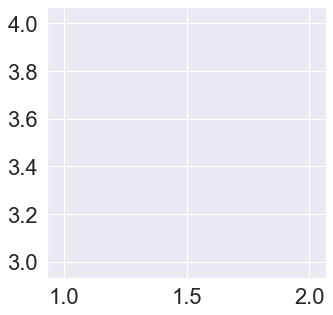

In [42]:
# prepare shape list for swarmplot.
sns.set(rc={'figure.figsize':(5, 5)}, font_scale = 2)
_, ax = plt.subplots(1,1)
# dummy plots, just to get the Path objects
a = ax.scatter([1,2],[3,4], marker='o')
b = ax.scatter([1,2],[3,4], marker='^')
c = ax.scatter([1,2],[3,4], marker='v')
d = ax.scatter([1,2],[3,4], marker='s')
e = ax.scatter([1,2],[3,4], marker='d')
f = ax.scatter([1,2],[3,4], marker='*')
g = ax.scatter([1,2],[3,4], marker='D')

shape1, = a.get_paths()
shape2, = b.get_paths()
shape3, = c.get_paths()
shape4, = d.get_paths()
shape5, = e.get_paths()
shape6, = f.get_paths()
shape7, = g.get_paths()

shape_list = [shape1, shape2, shape3, shape4, shape5, shape6, shape7]

a.remove()
b.remove()
c.remove()
d.remove()
e.remove()
f.remove()
g.remove()


C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.4% of the points cannot be 

42
${p}$=0.027
${p}$=0.026
${p}$=0.046


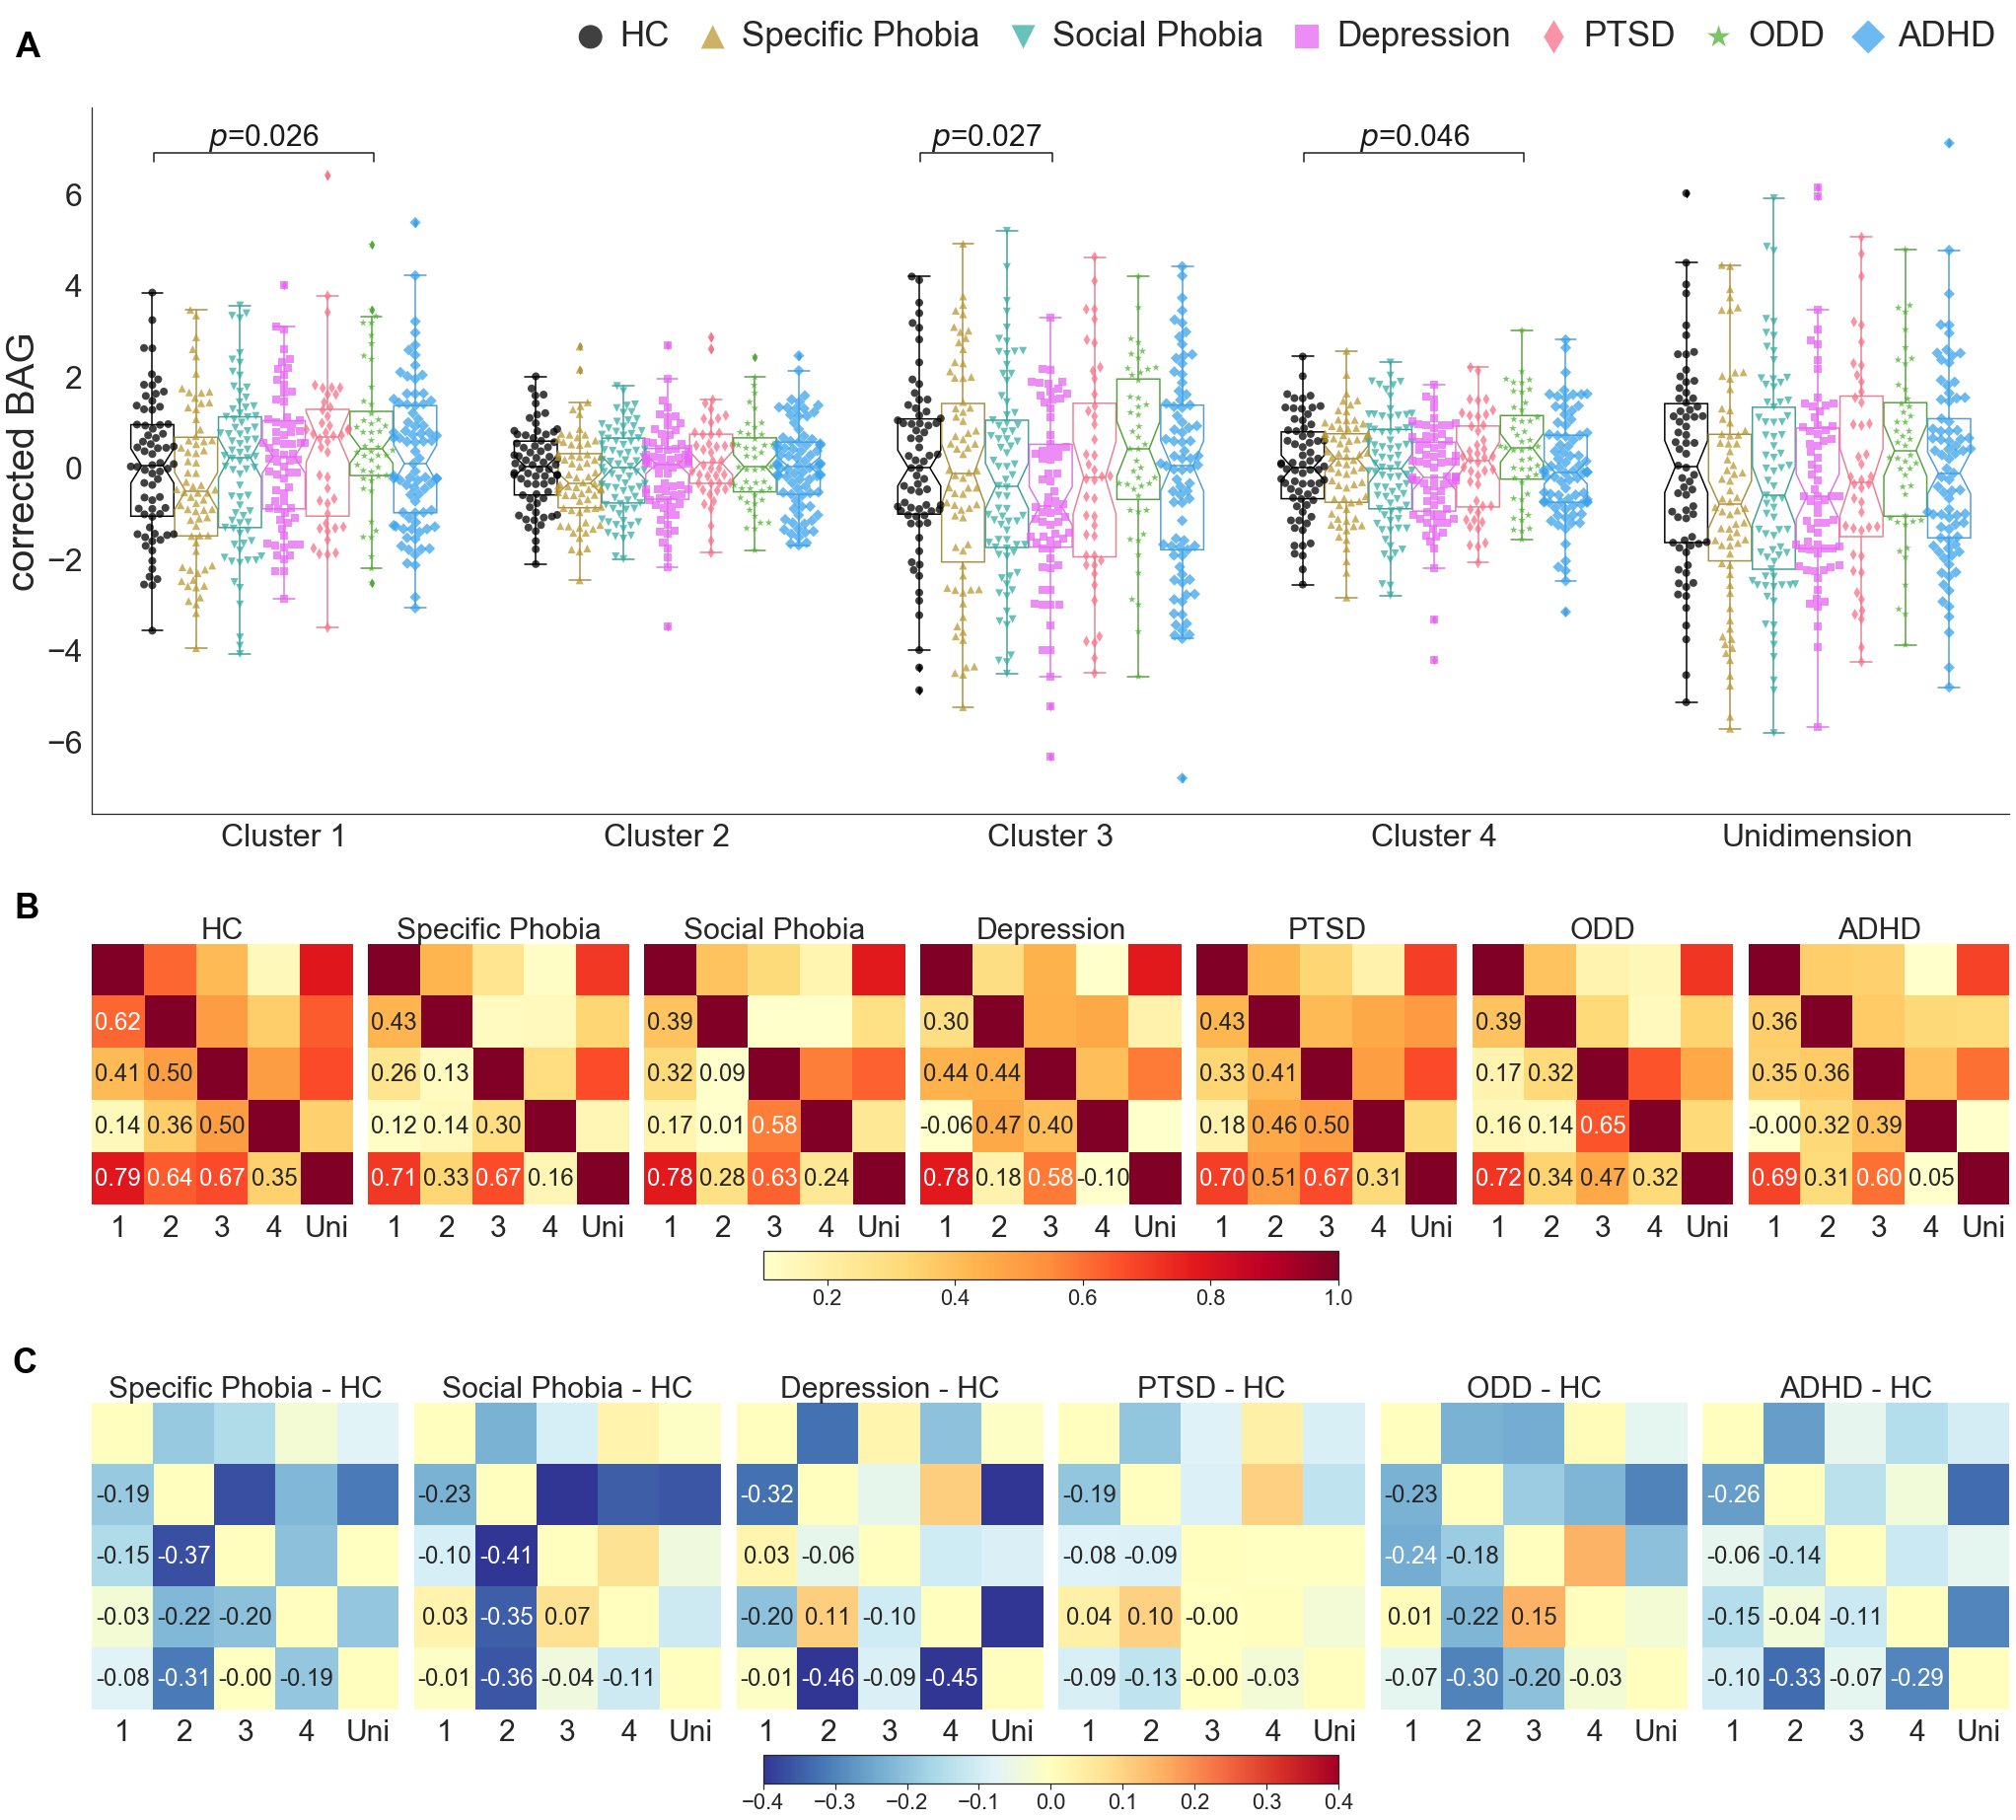

In [43]:
def box_heatmap_plot(scatter_data, permutation_report, p_thresh = .1):
    
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(30, 32)}, font_scale = 2)
    sns.set_style("white")

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)
    group_label = list(scatter_data['group2'].unique().sort_values())
    num_group = len(group_label)

    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(nrows=7, ncols=num_group*(num_group-1), left=0.05, right=0.95, wspace=0.5, hspace = .25)
    
    ax1 = fig.add_subplot(gs[0:3, :])
    
    ax2_list = []
    gs_coord1 = range(0, num_group*(num_group-1), num_group-1)
    gs_coord2 = range(num_group-1, num_group*(num_group-1)+1, num_group-1)
    for i_subplot in range(num_group):
        ax2_list.append(fig.add_subplot(gs[3:5, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))
        
    ax3_list = []  
    gs_coord1 = range(0, num_group*(num_group-1), num_group)
    gs_coord2 = range(num_group, num_group*(num_group-1)+1, num_group)
    for i_subplot in range(num_group-1):
        ax3_list.append(fig.add_subplot(gs[5:, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))

    ############ box plot: ###########################
    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data2, 
                  hue = 'group2', dodge=True, ax = ax1, facecolors='none',
                  palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75, size=8)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data2, hue = 'group2', palette = colors,
                notch = True, ax = ax1)
    
    ## use different shape in swarmplot: (useful for blackwhite figures)
    c = ax1.collections
    print(len(c))
    for i in range(len(shape_list)):
        for j in range(5):
            a = c[i+j*7]
            a.set_paths([shape_list[i]])
            
    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    ax1.legend(c[:num_group], #the last n handles are for the legend. this is strange [-n:] does not work but [n:] works...
               group_label, 
               borderaxespad = 0., 
               loc = 'right', 
               columnspacing = 1.2,
               frameon = False, markerscale = 3, handlelength = .1,
               prop = {'size': 35}, title = '', bbox_to_anchor=(1, 1.1), ncol=7)
    ## end modify shape.
    
    ax1.set_xlabel('')
    ax1.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Unidimension'])
    ax1.set_ylabel('corrected BAG', size = 40)
    ax1.tick_params(axis='x', labelsize=32)
    ax1.tick_params(axis='y', labelsize=32)
    #ax1.set_xticklabels(cluster_idx, size = 35)
    
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    # Also fix the legend ## this does not make any difference so comment it.
#     for legpatch in ax1.get_legend().get_patches():
#         col = legpatch.get_facecolor()
#         legpatch.set_edgecolor('None')
#         legpatch.set_facecolor('None')
   

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color, size = 30)


    y_base = np.array([1]*num_cluster)*6.7

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    ax1.text(-.7, 9, "A", horizontalalignment='left', size=35, color='black', weight='bold')
    
    ############################# heat map #################################
    
    idx = 0
    idx2= 0
    for i_group in group_label:
        
        scatter_data_group = scatter_data2.loc[scatter_data2['group2']==i_group,['SUBJID', 'cluster2', 'BAG']]
        scatter_data_group = scatter_data_group.pivot(index='SUBJID', columns='cluster2', values='BAG')
        matrix = scatter_data_group.corr().values
        
        # partial correlation:
        scatter_data_sex = scatter_data2.loc[scatter_data2['group2']==i_group, ['SUBJID', 'Sex']]
        scatter_data_sex.replace({'Sex': {'F': 0, 'M': 1}}, inplace = True)
        cluster_col = scatter_data_group.columns.tolist()
        scatter_data_group.columns = cluster_col
        scatter_data_group.reset_index(inplace = True)
        scatter_data_group = scatter_data_group.merge(scatter_data_sex, how = 'left', on = 'SUBJID')
        scatter_data_group.set_index('SUBJID')
        for x in range(len(cluster_col)-1):
            for y in range(x+1, len(cluster_col)):
                pcor = scatter_data_group[[cluster_col[x], cluster_col[y], 'Sex']].pcorr()
                matrix[x,y] = pcor.values[0,1]
                matrix[y,x] = pcor.values[0,1]
        

        ## panel B:
        cmap_b = 'YlOrRd'
        # draw upper triangular heat map without annotation:
        im = sns.heatmap(matrix, annot=False, ax = ax2_list[idx], 
                         cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        # draw lower triangular heat map with annotation:
        mask = np.triu(np.ones_like(matrix, dtype=np.bool))
        im = sns.heatmap(matrix, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                         ax = ax2_list[idx], cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        
        ax2_list[idx].set_ylabel("")
        ax2_list[idx].set_yticklabels("")
        ax2_list[idx].set_title(i_group, size = 30)
        ax2_list[idx].set_xlabel('')
        ax2_list[idx].set_xticklabels(['1', '2', '3', '4', 'Uni'], rotation=0, size = 30)

        cmap_c = 'RdYlBu_r'
        ## panel C:
        if idx==0:
            matrix_hc = matrix
        else:
            # draw upper triangular heat map without annotation:
            im2 = sns.heatmap(matrix-matrix_hc, annot=False, ax = ax3_list[idx2], 
                         cbar = False, cmap=cmap_c, square=True, vmin=-.4, vmax=0.4)
            # draw lower triangular heat map with annotation:
            mask = np.triu(np.ones_like(matrix, dtype=np.bool))
            im2 = sns.heatmap(matrix-matrix_hc, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                             ax = ax3_list[idx2], cbar = False, cmap=cmap_c, square=True, vmin=-.4, vmax=0.4)

            ax3_list[idx2].set_ylabel("")
            ax3_list[idx2].set_yticklabels("")
            ax3_list[idx2].set_title(i_group + ' - HC', size = 30)
            ax3_list[idx2].set_xlabel('')
            ax3_list[idx2].set_xticklabels(['1', '2', '3', '4', 'Uni'], rotation=0, size = 30)
            
            idx2+=1
        
        idx+=1
            
    
    mappable = im.get_children()[0]
    plt.colorbar(mappable, ax = ax2_list, shrink = .3, location="bottom", pad = .1,)
    
    mappable = im2.get_children()[0]
    plt.colorbar(mappable, ax = ax3_list, shrink = .3, location="bottom", pad = .1,)
    
    ax2_list[0].text(-1.5, -.5, "B", horizontalalignment='left', size=35, color='black', weight='bold')
    ax3_list[0].text(-1.3, -.5, "C", horizontalalignment='left', size=35, color='black', weight='bold')
    
    #plt.tight_layout()
    plt.show()
    return(fig)

f = box_heatmap_plot(scatter_data, permutation_report, p_thresh = .07)
f.savefig(output_dir+'/figure4_box_heatmap_plot_age_gap_' + method + '_disorder_'+ model + '.png', dpi=600,
          bbox_inches = 'tight', pad_inches = 0.1)


In [102]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(rc={'figure.figsize':(9, 6)}, font_scale = 2)
# sns.set(style="whitegrid")
# tips = sns.load_dataset("tips")

# fig, ax = plt.subplots(1,1)
# # dummy plots, just to get the Path objects
# a = ax.scatter([1,2],[3,4], marker='s')
# b = ax.scatter([1,2],[3,4], marker='^')
# square_mk, = a.get_paths()
# triangle_up_mk, = b.get_paths()
# a.remove()
# b.remove()

# ax = sns.swarmplot(x="day", y="total_bill", hue="sex",data=tips,size=8,ax=ax, dodge=True)
# ax = sns.boxplot(x="day", y="total_bill", hue="sex",data=tips, ax=ax, dodge=True)
# N_hues = len(pd.unique(tips.sex))

# c = ax.collections
# for a in c[::N_hues]:
#     a.set_paths([triangle_up_mk])
# for a in c[1::N_hues]:
#     a.set_paths([square_mk])
# #update legend
# # ax.legend(c[2:],['x', 'y'])
# ax.legend(c[-2:],['x', 'y'])

# plt.show()

In [ ]:
# from statsmodels.stats.multitest import multipletests
# import numpy as np

# pd.options.display.float_format = '{:,.5f}'.format

# permutation_report_corrected = permutation_report.copy()

# # correction_method = 'hommel'
# correction_method = 'holm'
# # correction_method = 'fdr_by' 
# # correction_method = 'fdr_bh'
# # correction_method = 'fdr_tsbh' 
# # correction_method = 'fdr_gbs'


# num_row = permutation_report_corrected.shape[0]
# for i in range(1, num_row):
#     output = multipletests(permutation_report.iloc[i,1:],alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
#     permutation_report_corrected.iloc[i, 1:] = output[1]

# permutation_report4 = permutation_report_corrected.copy()

# permutation_report4.iloc[:,1:] = permutation_report4.iloc[:,1:].astype(float).round(3).astype(str)

# permutation_report4[permutation_report_corrected.iloc[:,1:].le(2)] = permutation_report4[
#     permutation_report_corrected.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

# permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.05)] = permutation_report4[
#     permutation_report_corrected.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

# permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.01)] = permutation_report4[
#     permutation_report_corrected.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

# permutation_report4.to_csv(output_dir+'/out04_permutation_disorder_table_' + correction_method + 'each_disorder_' + model + '.csv')
# permutation_report4

In [ ]:

# f = box_heatmap_plot(scatter_data, permutation_report_corrected, p_thresh = .1)
# f.savefig(output_dir+'/figure4_box_heatmap_plot_age_gap_corrected' + method + '_each_disorder_'+ model + '.png', dpi=300,
#           bbox_inches = 'tight', pad_inches = 0.5)


In [ ]:
from statsmodels.stats.multitest import multipletests
import numpy as np

pd.options.display.float_format = '{:,.5f}'.format

row_ind = [0,2,5]
permutation_report_corrected = permutation_report.copy()
# we just do multiple comparision for groups with significant interaction terms: (specific phobia, depression, adhd)
permutation_report_corrected = permutation_report_corrected.iloc[row_ind,:]

# correction_method = 'hommel'
# correction_method = 'holm'
# correction_method = 'fdr_by' 
correction_method = 'fdr_bh'
# correction_method = 'fdr_tsbh' 
# correction_method = 'fdr_gbs'

# num_row = permutation_report_corrected.shape[0]
# for i in range(1, num_row):
#     output = multipletests(permutation_report.iloc[i,1:],alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
#     permutation_report_corrected.iloc[i, 1:] = output[1]
p_values = permutation_report_corrected.iloc[:,1:].values.flatten()
output = multipletests(p_values, alpha=0.05, method=correction_method, is_sorted=False, returnsorted=False)
p_values_table = np.reshape(output[1], (len(row_ind), 5))
permutation_report_corrected.iloc[:, 1:] = p_values_table


permutation_report4 = permutation_report_corrected.copy()

permutation_report4.iloc[:,1:] = permutation_report4.iloc[:,1:].astype(float).round(3).astype(str)

permutation_report4[permutation_report_corrected.iloc[:,1:].le(2)] = permutation_report4[
    permutation_report_corrected.iloc[:,1:].le(2)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.05)] = permutation_report4[
    permutation_report_corrected.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report4[permutation_report_corrected.iloc[:,1:].le(0.01)] = permutation_report4[
    permutation_report_corrected.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

# permutation_report4.to_csv(output_dir+'/out04_permutation_disorder_table_' + correction_method + '_' + model + '.csv')
permutation_report4

In [ ]:
output

In [ ]:
permutation_report_full2 = permutation_report_full.copy()
permutation_report_full2 = permutation_report_full2.iloc[row_ind,:]

# replace p values with corrected ones:
permutation_report_corrected2 = permutation_report_corrected.set_index('disorder')
permutation_report_full2.loc[:,(slice(None), 'p value')] = permutation_report_corrected2.values

permutation_report_full3 = permutation_report_full2.astype(float).round(3).astype(str)
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

# convert numeric value to strings with 3 decimal digits:

permutation_report_full3[permutation_report_full2.le(0)] = permutation_report_full3[
    permutation_report_full2.le(0)].astype(str).apply(lambda x : x.str[:6]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full3[permutation_report_full2.ge(0)] = permutation_report_full3[
    permutation_report_full2.ge(0)].astype(str).apply(lambda x : x.str[:5]).apply(lambda x : x.str.ljust(5, fillchar='0'))

permutation_report_full3[permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.05)] = permutation_report_full3[
    permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report_full3[permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.01)] = permutation_report_full3[
    permutation_report_full2.loc[:, (slice(None), 'p value')].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report_full3.to_csv(output_dir+'/out04_permutation_disorder_table_full_fdrcorrected_' + method + '_' + model + '.csv')
permutation_report_full3

In [ ]:
permutation_report_corrected2 = permutation_report.copy()
permutation_report_corrected2.iloc[[0,2,5],:] = permutation_report_corrected
permutation_report_corrected2.iloc[[1,3,4],:] = 1

f = box_heatmap_plot(scatter_data, permutation_report_corrected2, p_thresh = .1)
f.savefig(output_dir+'/figure4_box_heatmap_plot_age_gap_corrected' + method + '_disorder025_'+ model + '.png', dpi=300,
          bbox_inches = 'tight', pad_inches = 0.5)

In [37]:

scatter_data


index cluster        SUBJID Sex group  chronological age  brain age  \
4249    943     all  609987705265   M    HC           15.00000   15.12809   
815     435     1.0  604836600596   F    HC           11.00000   11.92325   
816     441     1.0  604908576947   F    HC           15.00000   17.32772   
817     449     1.0  605090380179   M    HC           12.00000   11.47865   
818     461     1.0  605266281282   M    HC           11.00000   14.37512   
...     ...     ...           ...  ..   ...                ...        ...   
1491    306     2.0  603260783630   F   ODD            9.00000   13.30233   
1494    318     2.0  603390032085   M   ODD           15.00000   16.23699   
1496    333     2.0  603519353680   M   ODD           18.00000   16.81191   
1498    337     2.0  603533144459   M   ODD           12.00000   13.61733   
3169    208     4.0  602260470547   F   ODD           18.00000   14.65292   

      brain age fit intersex  age gap  age gap corr group2     cluster2  
4249                16.83378  0.12809      -1.70570     HC  cluster all  
815                 12.80115  0.92325      -0.87790     HC    cluster 1  
816                 15.39014  2.32772       1.93758     HC    cluster 1  
817                 12.78426 -0.52135      -1.30561     HC    cluster 1  
818                 11.75062  3.37512       2.62451     HC    cluster 1  
...                      ...      ...           ...    ...          ...  
1491                14.63659  4.30233      -1.33426    ODD    cluster 2  
1494                15.80448  1.23699       0.43251    ODD    cluster 2  
1496                16.31081 -1.18809       0.50110    ODD    cluster 2  
1498                14.94127  1.61733      -1.32394    ODD    cluster 2  
3169                15.98324 -3.34708      -1.33032    ODD    cluster 4  

[2300 rows x 12 columns]

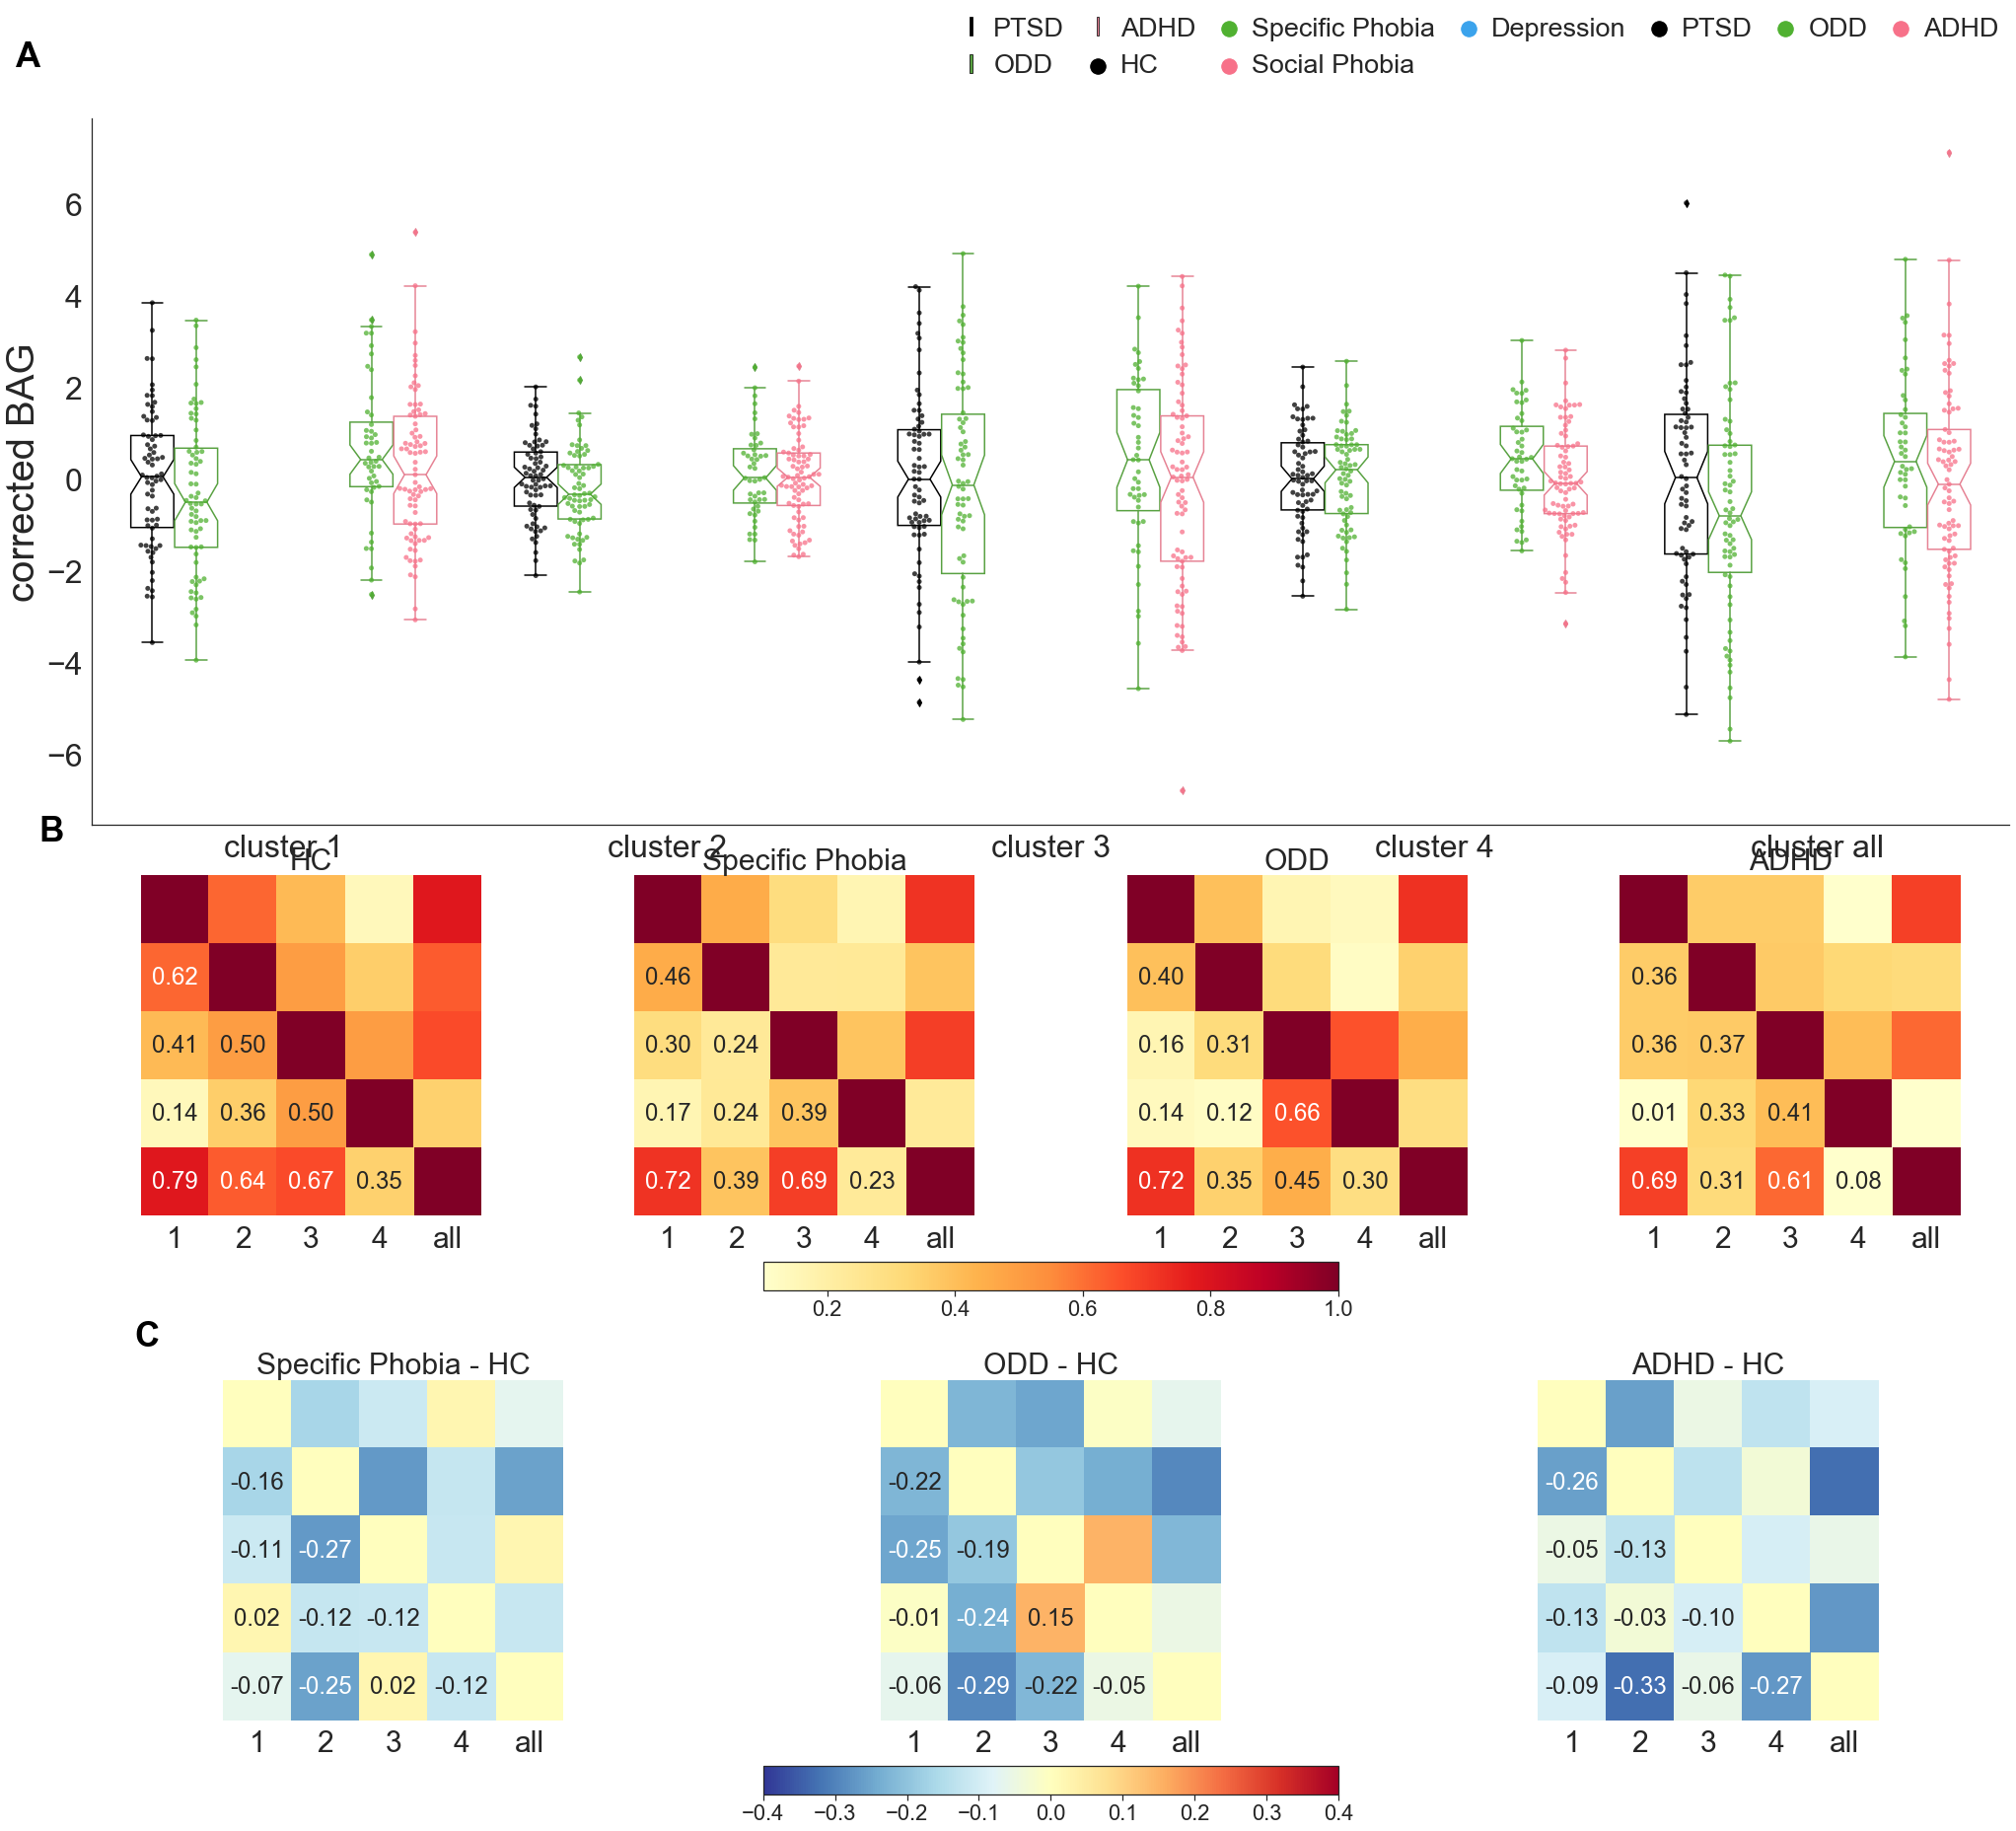

In [38]:
idx = scatter_data['group2'].isin(['HC', 'Specific Phobia', 'ODD', 'ADHD'])

scatter_data_drop = scatter_data[idx]

def box_heatmap_plot2(scatter_data, permutation_report, p_thresh = .07):
    
    from statannot import add_stat_annotation
    sns.set(rc={'figure.figsize':(30, 32)}, font_scale = 2)
    sns.set_style("white")

    scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

    cluster_idx = scatter_data['cluster2'].unique().sort_values()
    num_cluster = len(cluster_idx)
    group_label = list(scatter_data['group2'].unique().sort_values())
    num_group = len(group_label)

    fig = plt.figure(constrained_layout=False)
    gs = fig.add_gridspec(nrows=7, ncols=num_group*(num_group-1), left=0.05, right=0.95, wspace=0.5, hspace = .25)
    
    ax1 = fig.add_subplot(gs[0:3, :])
    
    ax2_list = []
    gs_coord1 = range(0, num_group*(num_group-1), num_group-1)
    gs_coord2 = range(num_group-1, num_group*(num_group-1)+1, num_group-1)
    for i_subplot in range(num_group):
        ax2_list.append(fig.add_subplot(gs[3:5, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))
        
    ax3_list = []  
    gs_coord1 = range(0, num_group*(num_group-1), num_group)
    gs_coord2 = range(num_group, num_group*(num_group-1)+1, num_group)
    for i_subplot in range(num_group-1):
        ax3_list.append(fig.add_subplot(gs[5:, gs_coord1[i_subplot]:gs_coord2[i_subplot]]))

    ############ box plot: ###########################
    colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
    colors = colors[::2] + colors[1::2] 

    sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data2, 
                  hue = 'group2', dodge=True, ax = ax1,
                  palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
                  alpha = .75)

    sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data2, hue = 'group2', palette = colors,
                notch = True, ax = ax1)

#     ax1.set(xlabel='', ylabel='BAG (with correction)')
    ax1.set_xlabel('')
    ax1.set_ylabel('corrected BAG', size = 40)
    ax1.tick_params(axis='x', labelsize=32)
    ax1.tick_params(axis='y', labelsize=32)
    #ax1.set_xticklabels(cluster_idx, size = 35)
    
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    # change boxplot style:
    for i,artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax1.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Also fix the legend
    for legpatch in ax1.get_legend().get_patches():
        col = legpatch.get_facecolor()
        legpatch.set_edgecolor('None')
        legpatch.set_facecolor('None')

    # remove legend of the boxplot
    # Get the handles and labels. For this example it'll be 2 tuples
    # of length 2n each.
    handles, labels = ax1.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the first/last n.
    n = len(group_label)
    l = ax1.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'right', columnspacing = 1.2,
                   frameon = False, markerscale =2, handlelength = .1,
                   prop = {'size': 27}, title = '', bbox_to_anchor=(1, 1.1), ncol=7)

    # add p value annotation manually:
    def add_annot(x1, x2, y, h, p, ax, color = 'k'):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
        if p>=.001:
            txt = "${p}$=%.3f" % p
        else:
            txt = "${p}$<.001"
            
        print(txt)
        ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color, size = 30)


    y_base = np.array([1]*num_cluster)*6.7

    for dis in range(permutation_report.shape[0]):
        for cluster in range(1, permutation_report.shape[1]):
            p = permutation_report.iloc[dis, cluster]
            if p<p_thresh:
                x1 = cluster-1-.34
                x2 = x1+(dis+1)*.115
                y = y_base[cluster-1]

                add_annot(x1, x2, y, .2, p, ax1, color = 'k')
                y_base[cluster-1]+=1.2

    ax1.text(-.7, 9, "A", horizontalalignment='left', size=35, color='black', weight='bold')
    
    ############################# heat map #################################
    
    idx = 0
    idx2= 0
    for i_group in group_label:
        
        scatter_data_group = scatter_data2.loc[scatter_data2['group2']==i_group,['SUBJID', 'cluster2', 'BAG']]
        scatter_data_group = scatter_data_group.pivot(index='SUBJID', columns='cluster2', values='BAG')
        matrix = scatter_data_group.corr()
        

        ## panel B:
        cmap_b = 'YlOrRd'
        # draw upper triangular heat map without annotation:
        im = sns.heatmap(matrix, annot=False, ax = ax2_list[idx], 
                         cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        # draw lower triangular heat map with annotation:
        mask = np.triu(np.ones_like(matrix, dtype=np.bool))
        im = sns.heatmap(matrix, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                         ax = ax2_list[idx], cbar = False, cmap=cmap_b, square=True, vmin=0.1, vmax=1)
        
        ax2_list[idx].set_ylabel("")
        ax2_list[idx].set_yticklabels("")
        ax2_list[idx].set_title(i_group, size = 30)
        ax2_list[idx].set_xlabel('')
        ax2_list[idx].set_xticklabels(['1', '2', '3', '4', 'all'], rotation=0, size = 30)

        cmap_c = 'RdYlBu_r'
        ## panel C:
        if idx==0:
            matrix_hc = matrix
        else:
            # draw upper triangular heat map without annotation:
            im2 = sns.heatmap(matrix-matrix_hc, annot=False, ax = ax3_list[idx2], 
                         cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)
            # draw lower triangular heat map with annotation:
            mask = np.triu(np.ones_like(matrix, dtype=np.bool))
            im2 = sns.heatmap(matrix-matrix_hc, mask=mask, annot=True, fmt=".2f", annot_kws={"size":24},
                             ax = ax3_list[idx2], cbar = False, cmap=cmap_c,square=True, vmin=-.4, vmax=0.4)

            ax3_list[idx2].set_ylabel("")
            ax3_list[idx2].set_yticklabels("")
            ax3_list[idx2].set_title(i_group+ ' - HC', size = 30)
            ax3_list[idx2].set_xlabel('')
            ax3_list[idx2].set_xticklabels(['1', '2', '3', '4', 'all'], rotation=0, size = 30)
            
            idx2+=1
        
        idx+=1
            
    
    mappable = im.get_children()[0]
    plt.colorbar(mappable, ax = ax2_list, shrink = .3, location="bottom", pad = .1,)
    
    mappable = im2.get_children()[0]
    plt.colorbar(mappable, ax = ax3_list, shrink = .3, location="bottom", pad = .1,)
    
    ax2_list[0].text(-1.5, -.5, "B", horizontalalignment='left', size=35, color='black', weight='bold')
    ax3_list[0].text(-1.3, -.5, "C", horizontalalignment='left', size=35, color='black', weight='bold')
    
    #plt.tight_layout()
    plt.show()
    return(fig)

f = box_heatmap_plot2(scatter_data_drop, permutation_report_corrected, p_thresh = .1)
f.savefig(output_dir+'/figure4_boxplot_age_gap_025' + method + '_disorder_'+ model +'_' + correction_method + '.png', dpi=300)

In [39]:
scatter_data2['cluster2'].unique().sort_values()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


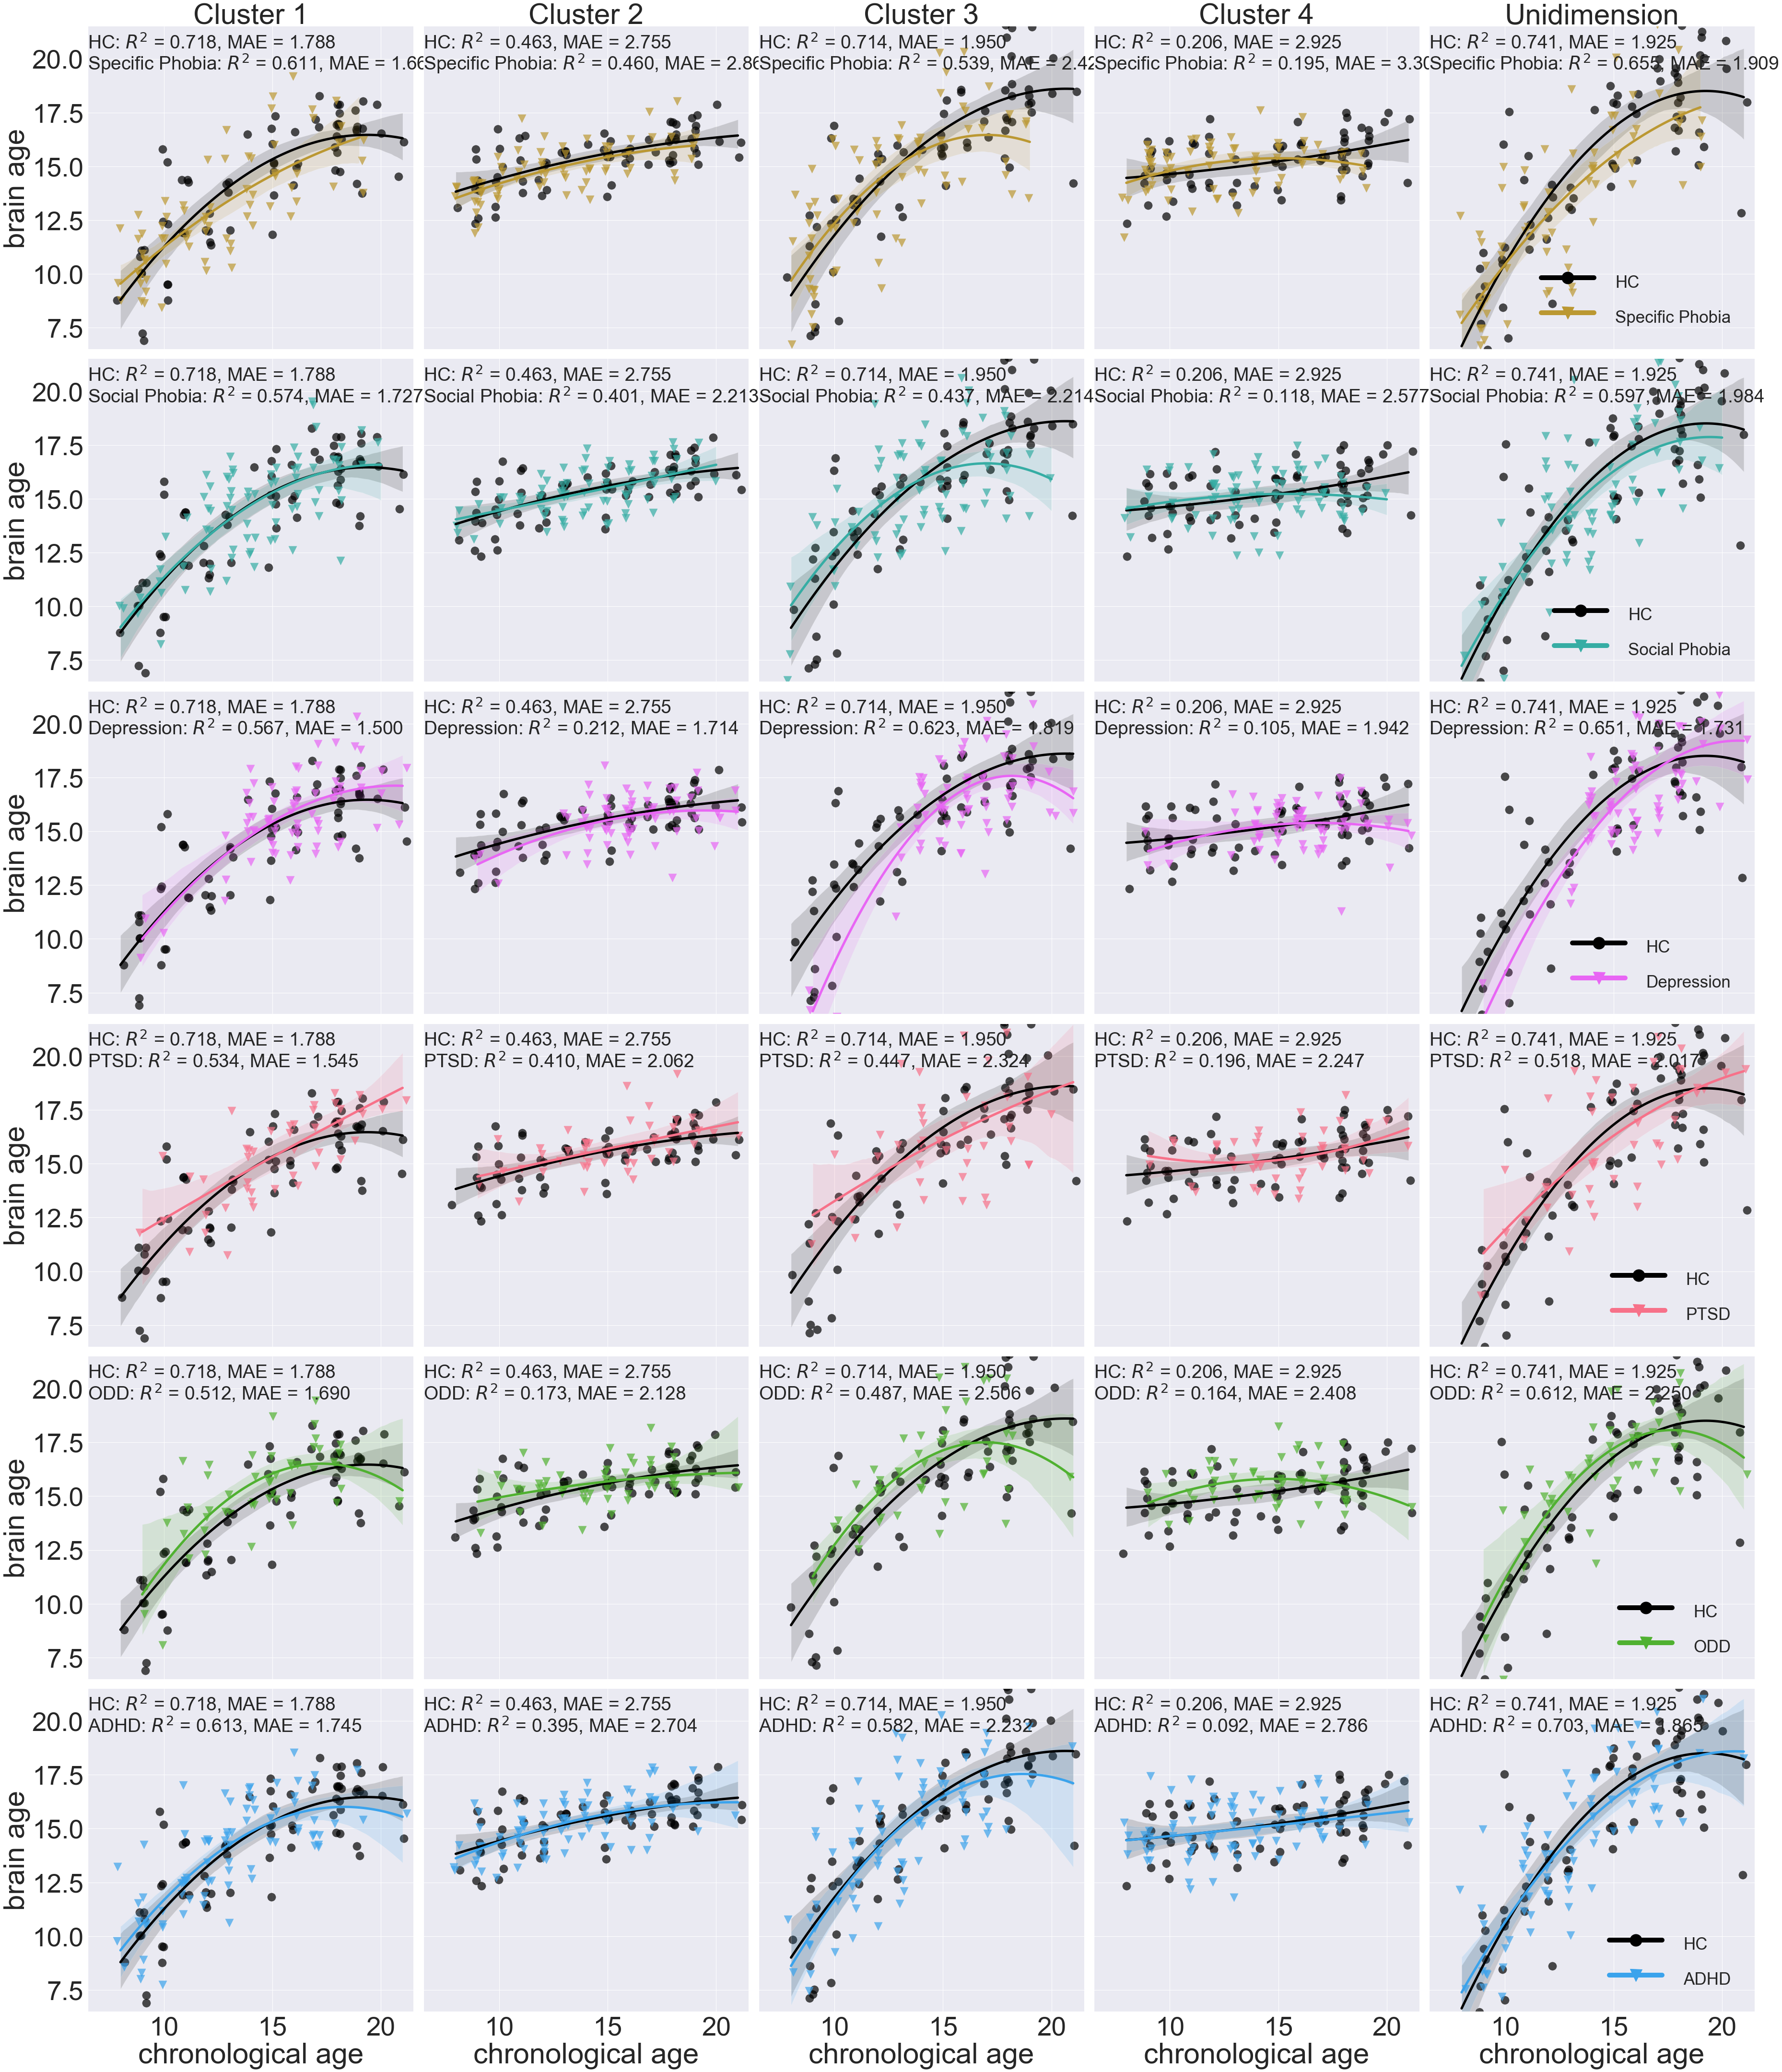

In [61]:
import matplotlib.lines as mlines

sns.set(rc={'figure.figsize':(6, 5.2)}, font_scale = 5)
text_size = 45

group_label = ['HC', 'Specific Phobia', 'Social Phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
# group_label = ['HC', 'Specific phobia', 'Depression', 'ADHD']
# group_label = ['HC', 'Specific phobia', 'Social anxiety', 'ODD', 'ADHD']

# colors = sns.color_palette("RdBu_r", 7)
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
colors = colors[::2] + colors[1::2] 

scatter_para = {'alpha': 0.7, 's': 300, 'linewidth': 0.25}

def plot_result_disorder(plot_data, group_label):

    plot_data['plot_row'] = 1
    column_title = plot_data['cluster2'].unique().sort_values()
    num_cluster = len(plot_data['cluster2'].unique())-1
    column_title2 = ['Cluster ' + str(n) for n in range(1, num_cluster+1)] + ['Unidimension']
    
    plot_data_list = []
    for i in range(1, len(group_label)):
        plot_data_i = plot_data[plot_data['group'].isin([group_label[0]]+[group_label[i]])]
        plot_data_i.loc[:,'plot_row'] = i
        plot_data_list.append(plot_data_i)
        
    plot_data_merge = pd.concat(plot_data_list, axis = 0)
    
#     cluster_name = plot_data['cluster'].unique()
#     variable_name = plot_data['group'].unique()

    g = sns.lmplot(x='chronological age', y='brain age', hue = 'group', 
                   col = 'cluster2', row = 'plot_row', palette = colors, 
                   data = plot_data_merge, fit_reg=True, #sharex = True, sharey = True, \
                   facet_kws = {'sharex':True, 'sharey':True},
                   scatter_kws=scatter_para, 
                   line_kws = {'lw': 5},
                   x_jitter = .2, order = 2,\
                   markers = ['o', 'v', 'v', 'v', 'v', 'v', 'v'],
                   height=10.27, aspect=9.17/8.27, legend = False)

    g.axes[0,0].set_xlim(6.5, 21.5)
    g.axes[0,0].set_ylim(6.5, 21.5)

    # comment this to check if column labels are correct:
    for col in range(len(column_title2)):
        g.axes[0, col].set_title(column_title2[col])
        for row in range(1,len(group_label)-1):
            g.axes[row, col].set_title('')
    
#     plt.setp(g._legend.get_title(), fontsize=45)
#     g._legend.set_title('')
#     for lh in g._legend.legendHandles[:2]: 
#         lh.set_alpha(1)
#         lh._sizes = [200] 
    
    # add legend for each row:
    for row in range(len(group_label)-1):
        ## create custom legend for regplot:
        hc_line = mlines.Line2D([], [], color=colors[0], marker='o',linewidth=10,
                          markersize=25, label='HC')
        dis_line = mlines.Line2D([], [], color=colors[row+1], marker='v', linewidth=10, #lineStyle = 'dashed',
                                  markersize=25, label=group_label[row+1])
    
        g.axes[row, -1].legend(handles=[hc_line, dis_line], 
                               loc = 'lower right',frameon=False)
        plt.setp(g.axes[row, -1].get_legend().get_texts(), fontsize='35')
            
    # compute R squared for each group and cluster:
    for col in range(len(column_title)):
        chro_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                 'chronological age'].values
        brain_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                  'brain age'].values
        gender = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                               'Sex'].map({'F':0, 'M':1}).values
        
        label_hc = "HC: $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender), 
                                                     np.mean(np.abs(chro_age - brain_age)))
        
        for row in range(len(group_label)-1):
            chro_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                     'chronological age'].values
            brain_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                      'brain age'].values
            gender = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                   'Sex'].map({'F':0, 'M':1}).values
            
            label_dis = group_label[row+1]+ ": $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender),
                                                                            np.mean(np.abs(chro_age - brain_age)))
            
            g.axes[row, col].text(6.5, 20.5, label_hc, fontsize = 39)
            g.axes[row, col].text(6.5, 19.5, label_dis, fontsize = 39)
        
    plt.subplots_adjust(hspace=0.03, wspace=0.03)


plot_result_disorder(scatter_data, group_label)
plt.savefig(output_dir+'/figure4_scatter_merge_' + method + 'disorder' + model + '.png', dpi=300)


In [46]:
colors

['#000000', '#bb9832', '#36ada4', '#e866f4', '#f77189', '#50b131', '#3ba3ec']

C:\Users\Xin\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
C:\Users\X

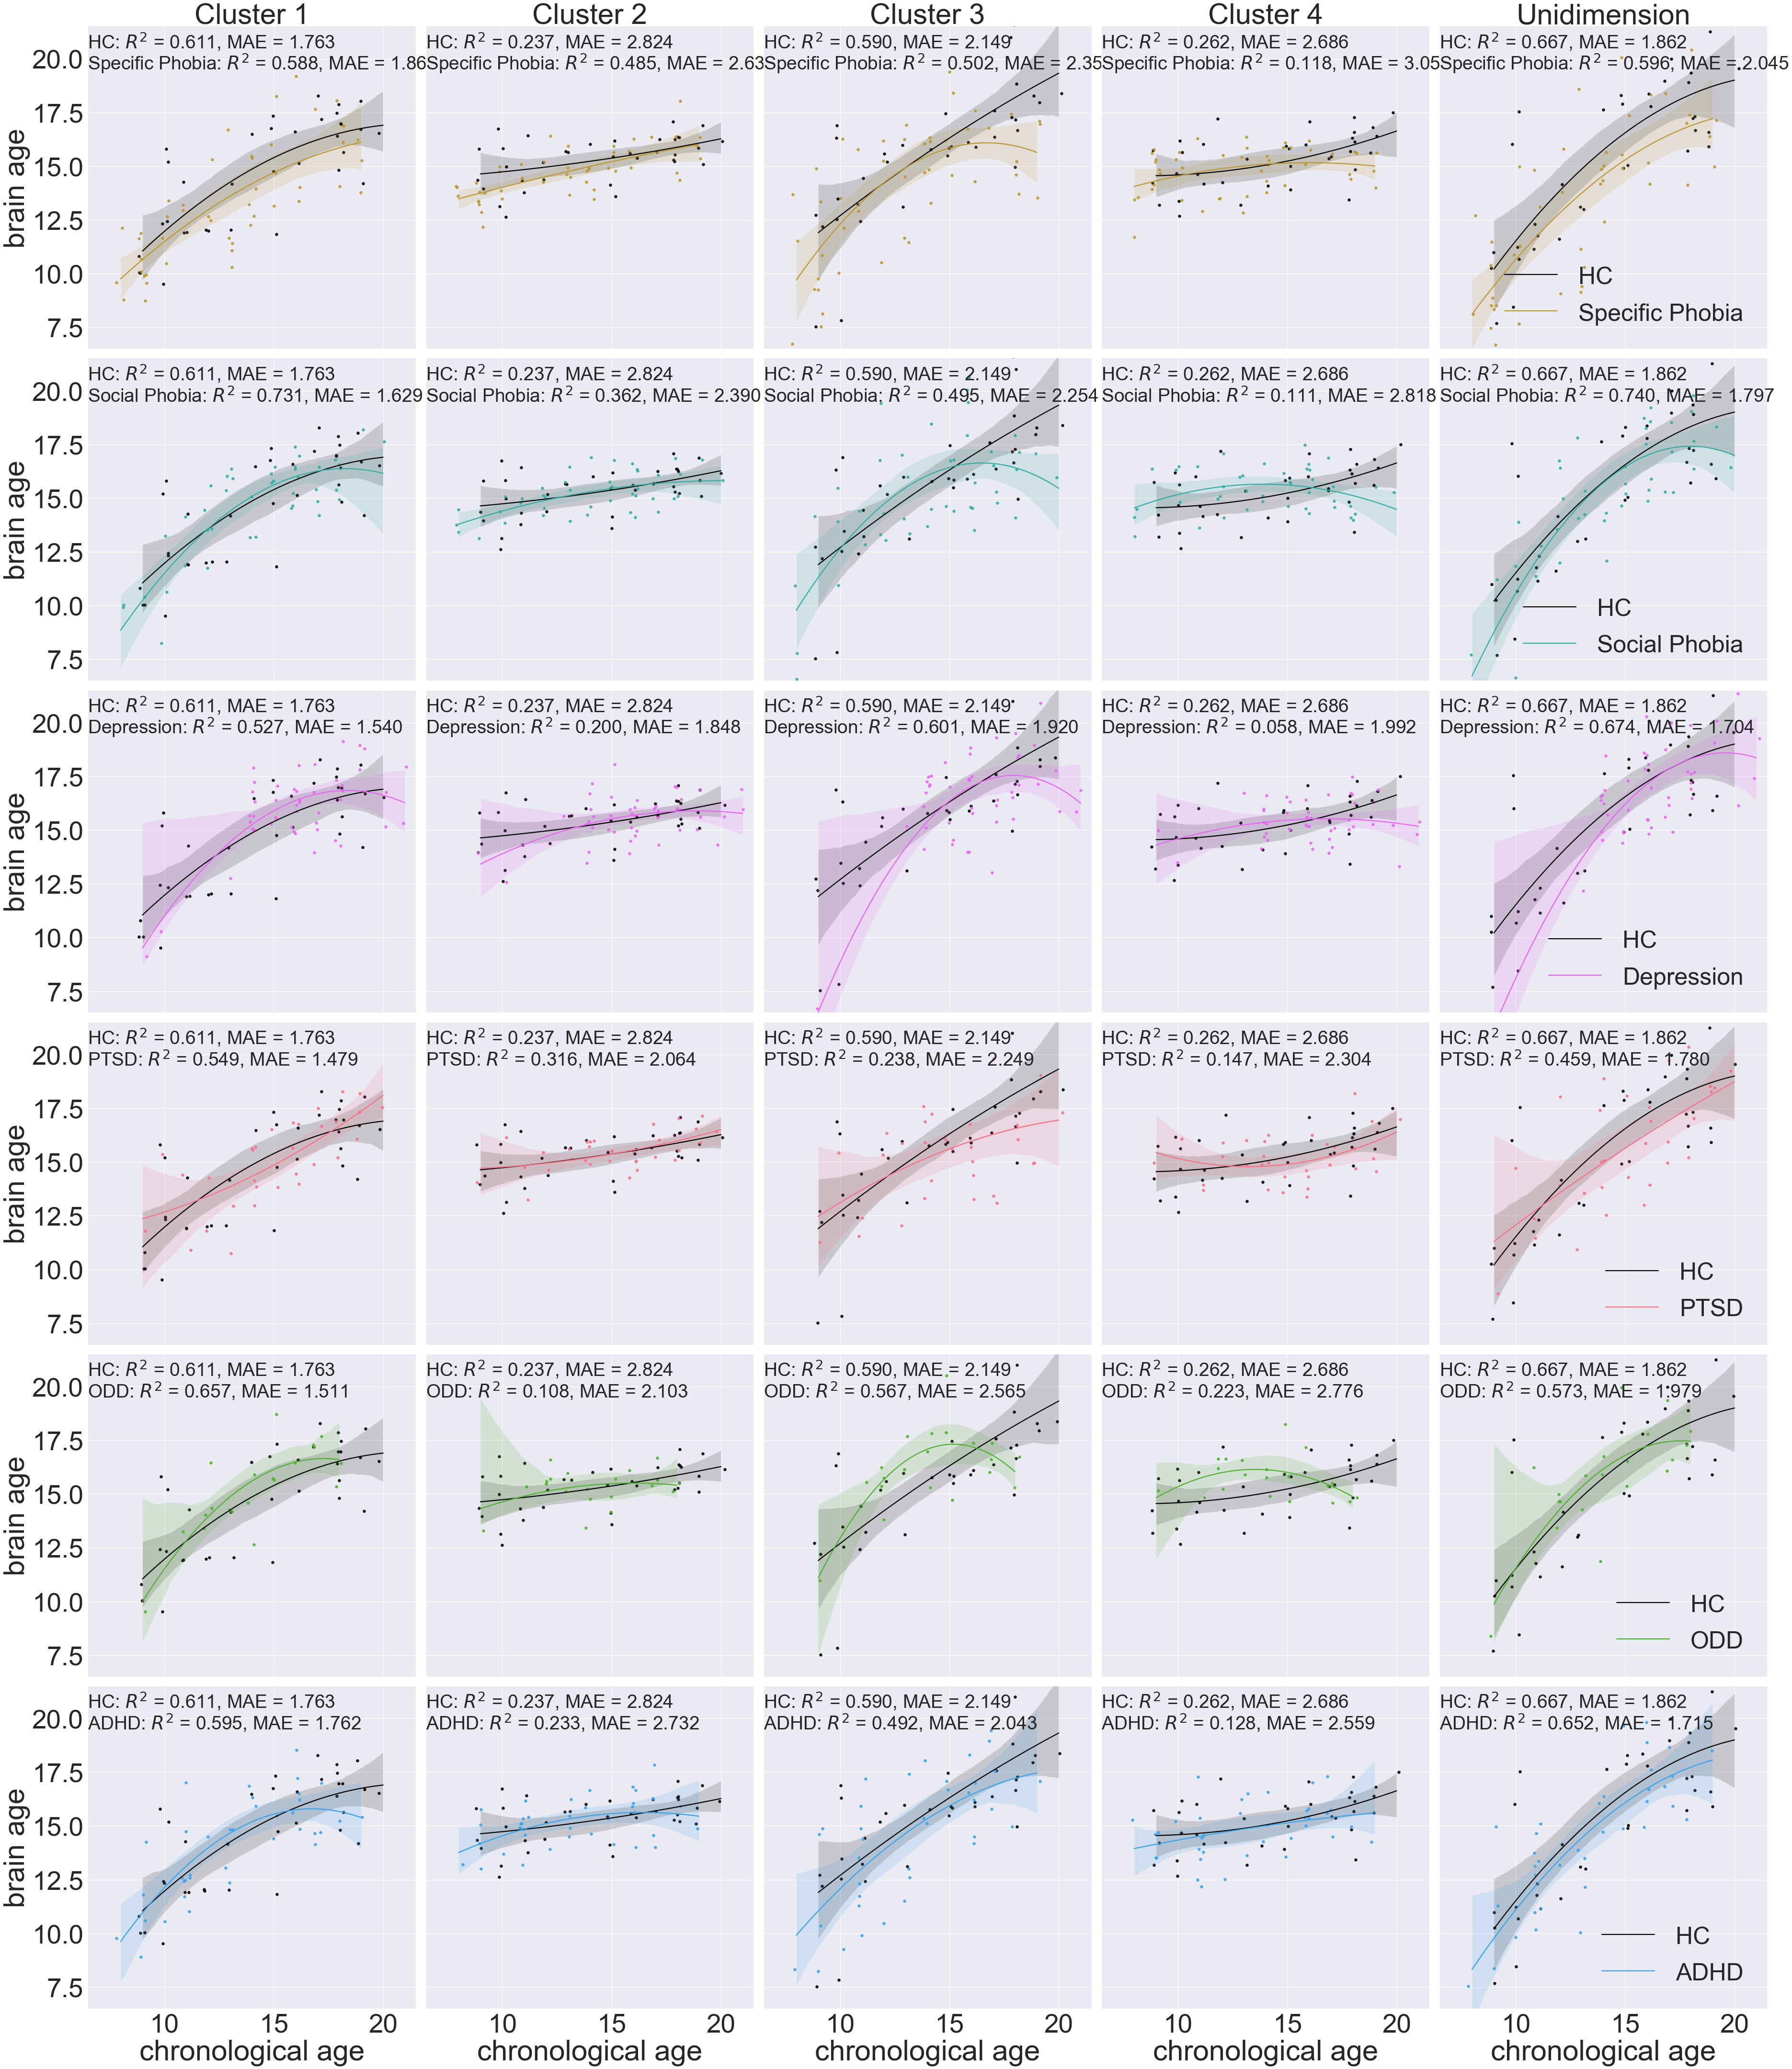

In [41]:
plot_result_disorder(scatter_data.loc[scatter_data['Sex']=='F',:], group_label)
plt.savefig(output_dir+'/figure4_scatter_merge_female_' + method + 'disorder' + model + '.png', dpi=300)

C:\Users\Xin\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
C:\Users\X

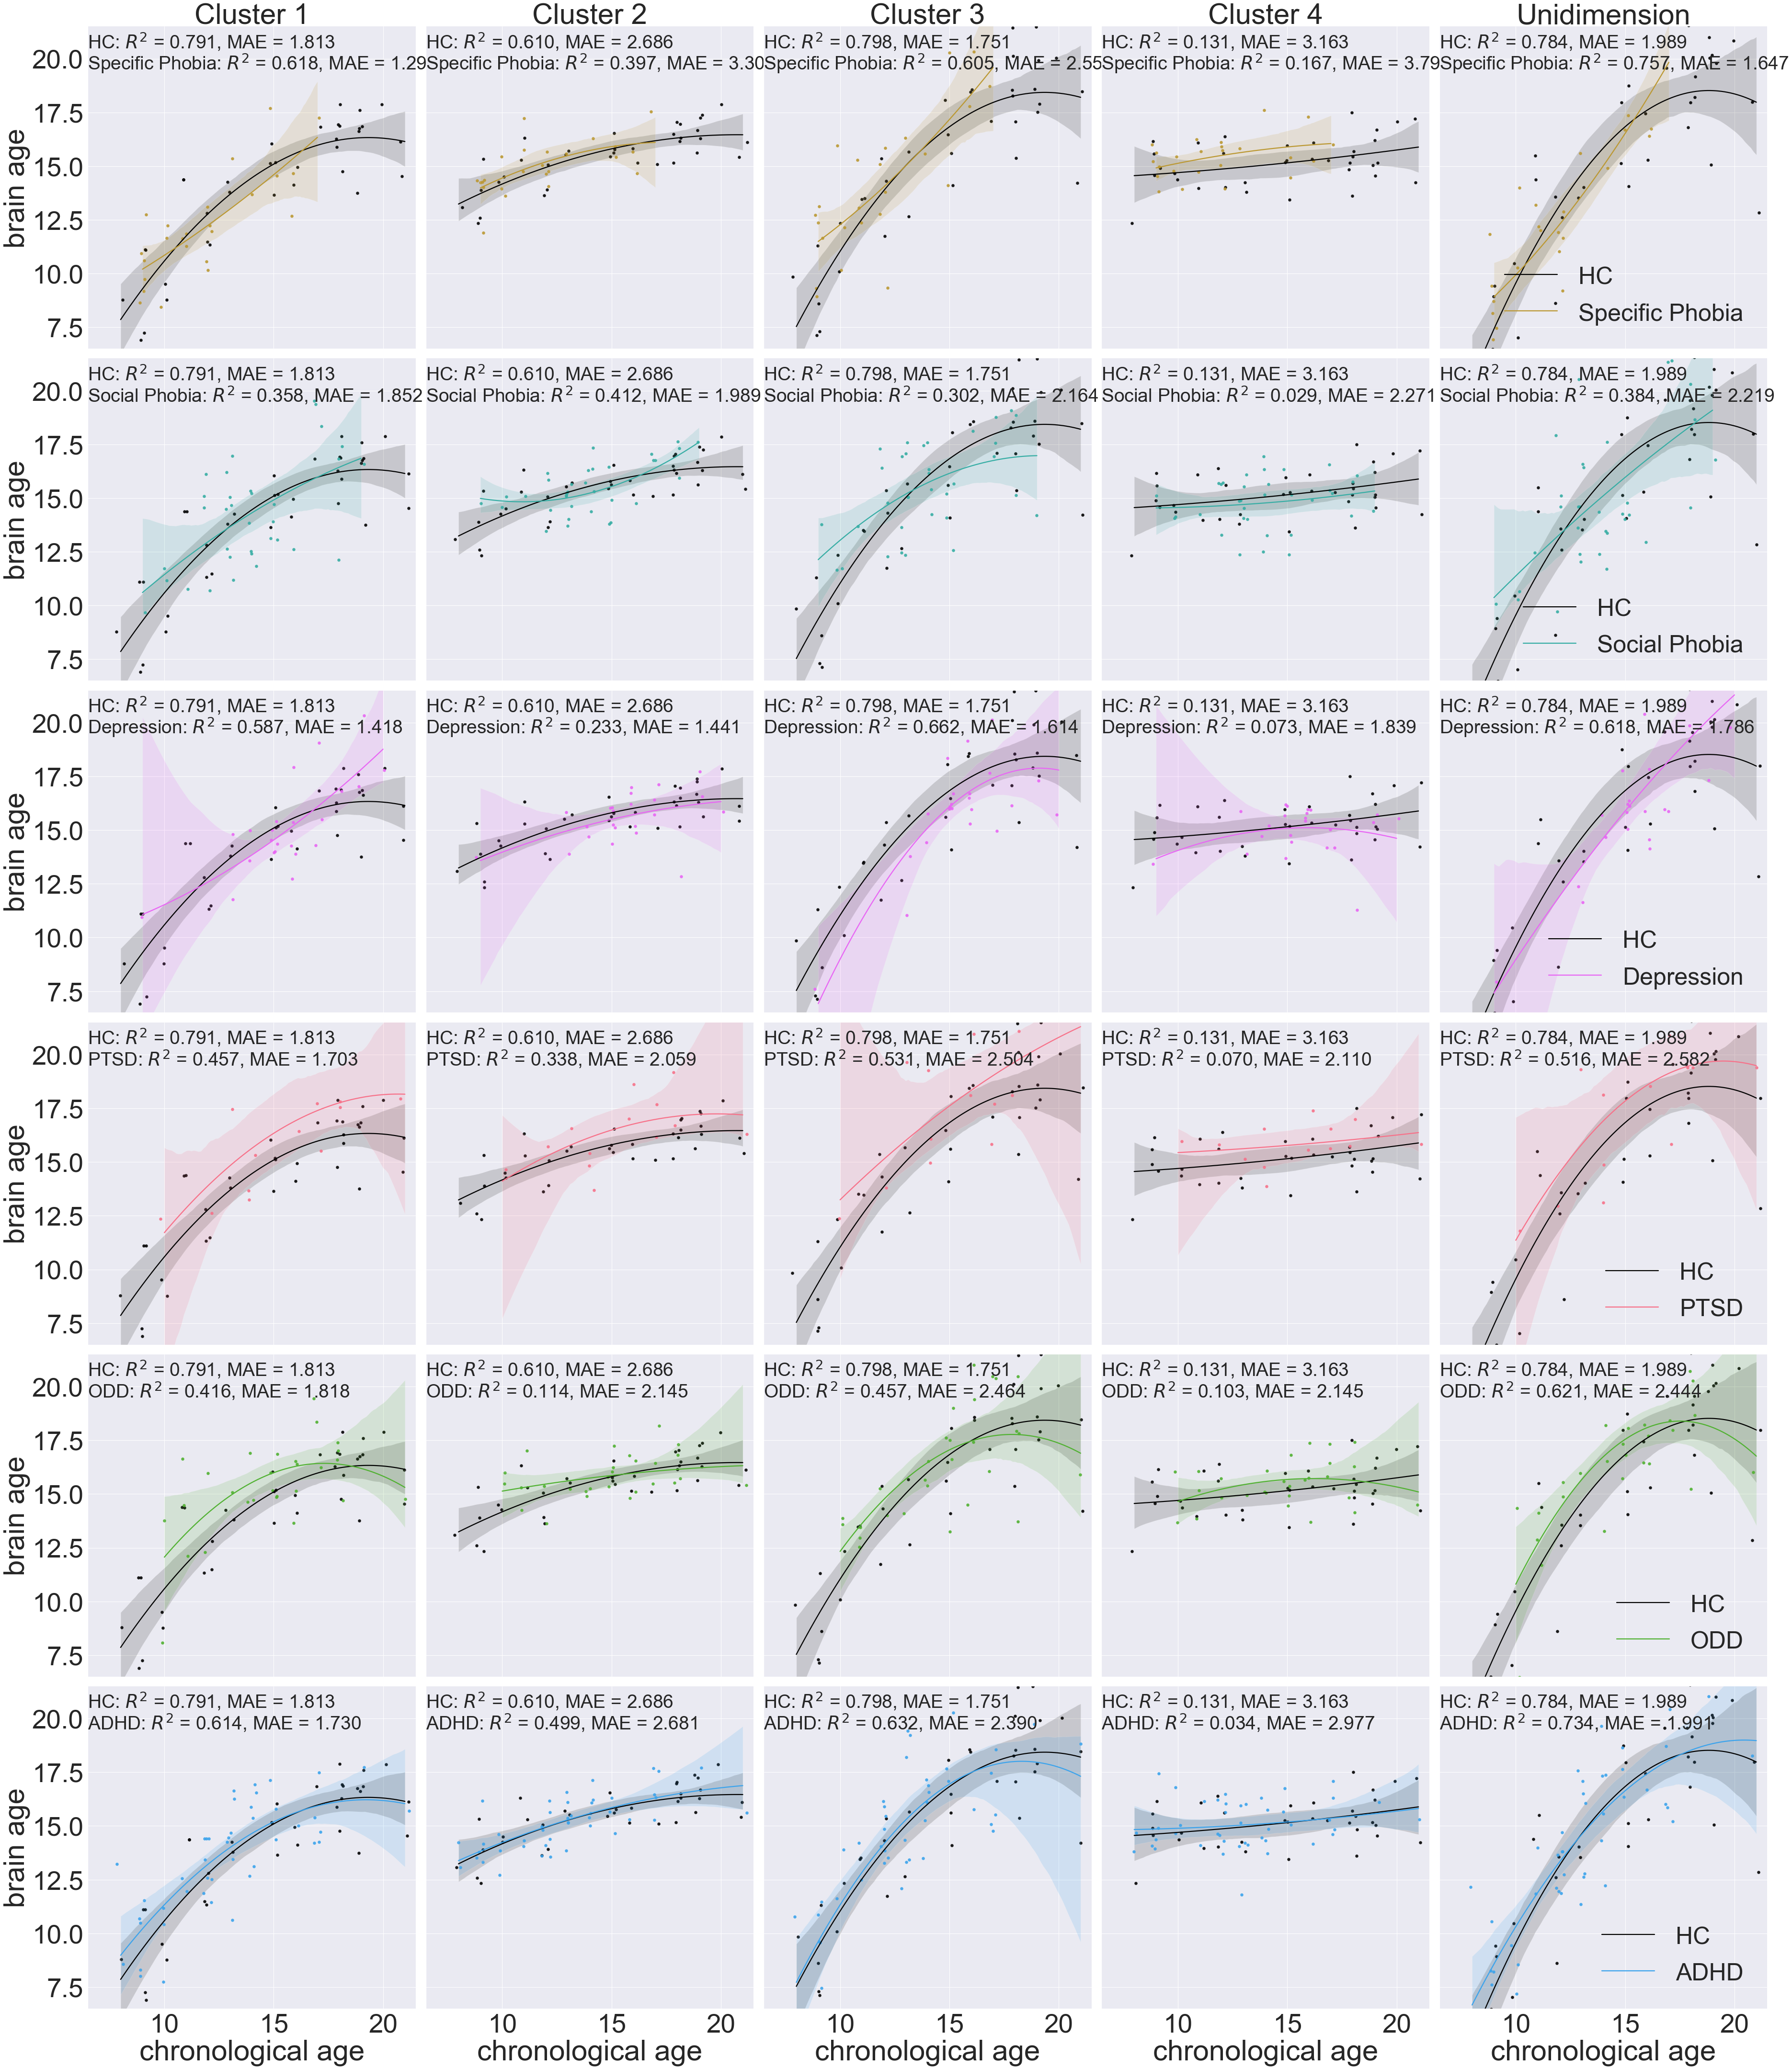

In [42]:
plot_result_disorder(scatter_data.loc[scatter_data['Sex']=='M',:], group_label)
plt.savefig(output_dir+'/figure4_scatter_merge_male_' + method + 'disorder' + model + '.png', dpi=300)